# Processing Data, Gaining Some Insights and Preparing Tokenizations

## Table Of Contents (ToC) - to do later


1. [Processing Data And Gaining Some Insights](#processing-data-and-gaining-some-insights)
   - *Introduction and objectives of the notebook.*
2. [Table Of Contents (ToC)](#table-of-contents-toc)
   - *This section links to all major parts of the notebook.*
3. [Early Processing](#early-processing)
   - *Removing NA values and filtering rows with incorrect dates.*
4. [Further Processing](#further-processing)
   - *XDXX*
5. [WHAT TEST](#WHAT)

## Early Processing 

*removing NA + filtering rows with wrong dates*

### Step 0: Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_parquet("Data/1.EarlyCleaned/cleaned_parquet/final/PubMedAbstracts_final.parquet")
df.head()

,uid,title,journal,pubdate,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,date,parsed_date
0,10150804,Evaluation of survival in medically treated pa...,"Journal of insurance medicine (New York, N.Y.)",None-01-01,General: Articles published in medical journal...,Iacovino J R,"New York Life Insurance Company, New York, USA.",Adolescent; Adult; Age Distribution; Chelation...,,N/A,1994-01-01,1994-01-01
1,9061841,Cohort versus cross-sectional design in large ...,Statistics in medicine,1994-Jan-15,General: In planning large longitudinal field ...,Feldman H A; McKinlay S M,"New England Research Institute, Inc., Watertow...",Analysis of Variance; Cluster Analysis; Cohort...,,N/A,1994-01-01,1994-01-15
2,9061840,Network analytic methods for epidemiological r...,Statistics in medicine,1994-Jan-15,General: The authors measure the efficacy of t...,Altmann M; Wee B C; Willard K; Peterson D; Gat...,"Division of Health Computer Sciences, Universi...",Analysis of Variance; Communicable Disease Con...,,N/A,1994-01-01,1994-01-15
3,9061838,"Estimating age, period and cohort effects usin...",Statistics in medicine,1994-Jan-15,General: To understand cancer aetiology better...,Holford T R; Zhang Z; McKay L A,"Department of Epidemiology and Public Health, ...","Age Factors; Cell Transformation, Neoplastic; ...",,N/A,1994-01-01,1994-01-15
4,16353609,A perspective on the hormonal abnormalities of...,Obesity research,1994-Jan-01,General: Studies in our laboratory and elsewhe...,Zumoff B; Strain G W,"Division of Endocrinology and Metabolism, Depa...",Adolescent; Adult; Estradiol; Estrone; Female;...,,N/A,1994-01-01,1994-01-01


In [4]:
# na per column 
df.isna().sum()

uid               0
title             0
journal           0
pubdate           0
abstract         14
authors           0
affiliations      0
mesh_terms        0
keywords          0
coi_statement     0
date              0
parsed_date       0
dtype: int64

### **Step 1**: Filtering rows + removal of missing records (missing abstracts are, after checking manually, missing from articles itself, they are **NOT** due to mistakes in the processing or data gathering)

In [5]:
missing_abstracts = df[df["abstract"].isna()]
print("Rows where 'abstract' is missing:")
missing_abstracts

Rows where 'abstract' is missing:


,uid,title,journal,pubdate,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,date,parsed_date
13973,7479089,Transverse temperature-gradient single-strand ...,Nucleic acids research,1995-Oct-25,None,Grace M B; Bambeck G S; Buzard G S; Weintraub B D,"Diabetes and Digestive and Kidney Diseases, Na...","Electrophoresis, Polyacrylamide Gel; Exons; Hu...",,N/A,1995-10-01,1995-10-25
396952,19951381,Probing the limits of regional tissue oxygenat...,"Critical care (London, England)",2009-01-01,None,Pinsky Michael R; Payen Didier,"Critical Care Medicine, Bioengineering, Cardio...",Hemoglobins; Humans; Microcirculation; Oxygen ...,,N/A,2009-01-01,2009-01-01
714156,28549132,Selective impairment of goal-directed decision...,Brain : a journal of neurology,2017-Jun-01,None,Reber Justin; Feinstein Justin S; O'Doherty Jo...,Department of Psychological and Brain Sciences...,Aged; Brain Diseases; Choice Behavior; Cogniti...,decision-making; devaluation; instrumental; re...,N/A,2017-06-01,2017-06-01
748429,29240851,Off Target But Hitting the Mark.,Journal of hospital medicine,2018-Apr-01,None,Kara Areeba; Mookherjee Somnath; Gavin Warren;...,"Inpatient Medicine, Indiana University Health ...",Abdominal Pain; Adult; Cholecystectomy; Doxycy...,,N/A,2018-04-01,2018-04-01
771404,30496332,Towards Scalable Hospital-Based Palliative Car...,Journal of hospital medicine,2018-Dec-01,None,Courtright Katherine R; O'Connor Nina R,"Division of Pulmonary, Allergy, and Critical C...",Hospitalists; Hospitals; Humans; Palliative Care,,N/A,2018-12-01,2018-12-01
771443,30475933,The vaginal wellness consultation for treatmen...,Seminars in cutaneous medicine and surgery,2018-Dec-01,None,Miller Misha D,Mohs Micrographic Surgery and Cutaneous Oncolo...,Atrophy; Catheter Ablation; Female; Humans; La...,,N/A,2018-12-01,2018-12-01
775681,30667412,Nudging Providers to Improve Sleep for Hospita...,Journal of hospital medicine,2019-Jan-01,None,Auriemma Catherine L; Greysen S Ryan,Division of Pulmonary and Critical Care Medici...,Choice Behavior; Decision Making; Goals; Human...,,N/A,2019-01-01,2019-01-01
775682,30667405,The Journal of Hospital Medicine in 2019 and B...,Journal of hospital medicine,2019-Jan-01,None,Shah Samir S,Divisions of Hospital Medicine and Infectious ...,Biomedical Research; Hospital Medicine; Humans...,,N/A,2019-01-01,2019-01-01
776638,30534643,Clinical Operations Research: A New Frontier f...,Journal of hospital medicine,2019-Jan-08,None,Kohn Rachel; Greysen S Ryan,"Department of Medicine, Perelman School of Med...",General Practice; Humans,,N/A,2019-01-01,2019-01-08
792798,31010740,RETRACTED: Comprehensive Analysis of the Expre...,Molecular therapy : the journal of the America...,2019-Jun-05,None,Sun Cheng-Cao; Li Shu-Jun; Hu Wei; Zhang Jian;...,Department of Occupational and Environmental H...,"Biomarkers, Tumor; Breast Neoplasms; Computati...",E2Fs; Kaplan-Meier Plotter; biomarkers; breast...,N/A,2019-06-01,2019-06-05


In [6]:
x = (df.shape)

# 1) Drop rows with missing abstract (14)
df = df.dropna(subset=["abstract"])

print("Removed missing abstract rows:")
print(x[0]-df.shape[0])

# 2) Drop rows with year == 2025
# first ensure parsed_date is datetime
df["parsed_date"] = pd.to_datetime(df["parsed_date"], errors="coerce")

#df = df[df["parsed_date"].dt.year != 2025]
# Exclude years 1994 and 2025 ; 1994 has low amount of articles
df = df[(df["parsed_date"].dt.year != 1994) & (df["parsed_date"].dt.year != 2025)]

print("Removed total rows:")
print(x[0] - df.shape[0])

Removed missing abstract rows:
14
Removed total rows:
1890


In [7]:
# Selecting only columns that we will be working with
df = df[["uid", "title", "journal", "abstract", "authors", "affiliations", "mesh_terms", "keywords", "coi_statement", "parsed_date"]].copy()

## Further Processing

In [8]:
df.columns

Index(['uid', 'title', 'journal', 'abstract', 'authors', 'affiliations',
       'mesh_terms', 'keywords', 'coi_statement', 'parsed_date'],
      dtype='object')

### Variable: `uid` + `parsed_date`

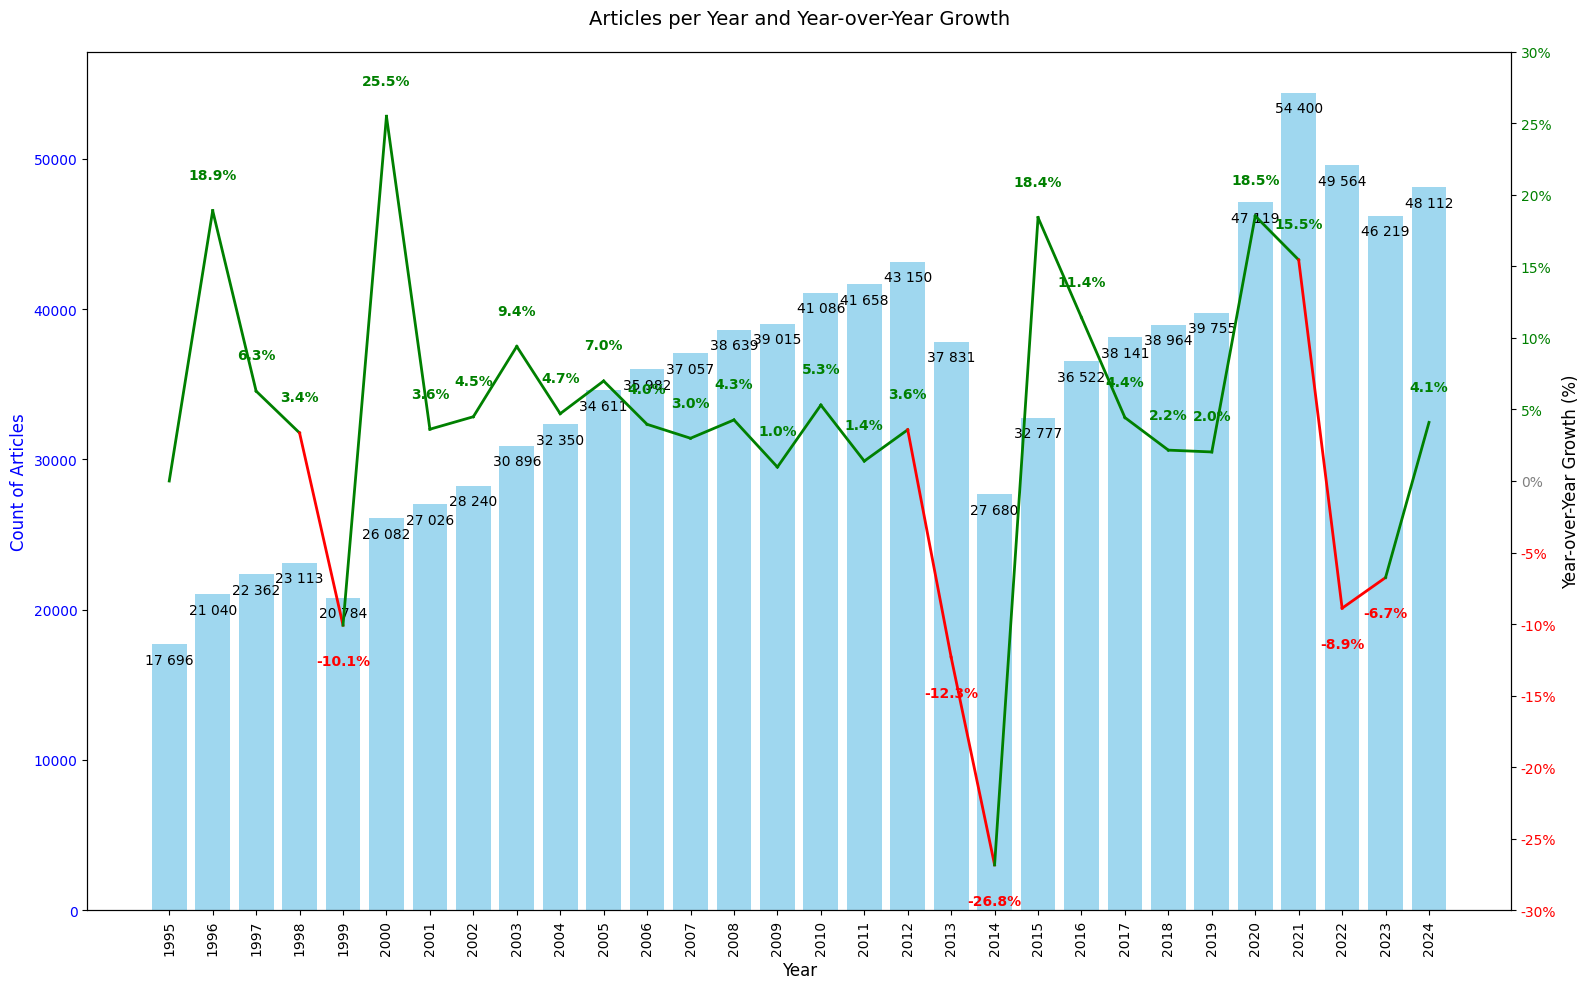

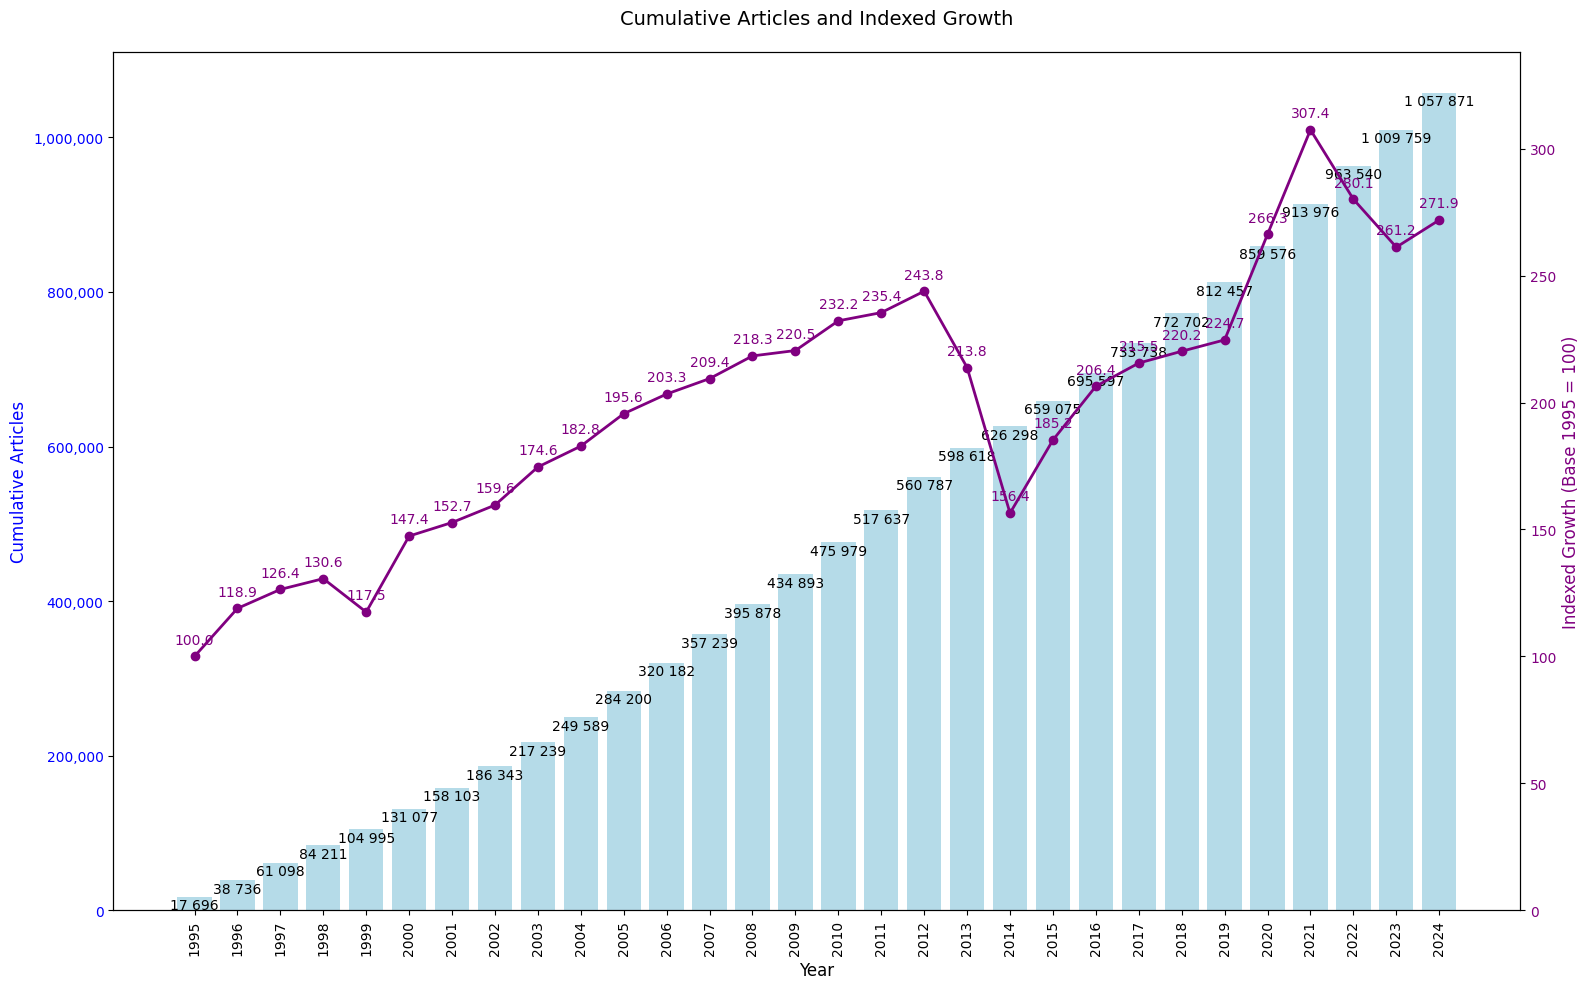

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `df` is your DataFrame and "parsed_date" is the column with dates
df["parsed_date"] = pd.to_datetime(df["parsed_date"], errors="coerce")

# Compute articles per year
articles_per_year = df.groupby(df["parsed_date"].dt.year)["uid"].count().sort_index()

# Compute Year-over-Year % change
growth_pct = articles_per_year.pct_change().fillna(0) * 100
growth_pct.iloc[0] = 0  # Set the first year's growth to 0 to avoid outliers

# Ensure all years from 1995 to 2024 are represented (even if no data for some years)
all_years = pd.Series(range(1995, 2025), name="Year")
articles_per_year = articles_per_year.reindex(all_years, fill_value=0)
growth_pct = growth_pct.reindex(all_years, fill_value=0)

# Compute cumulative number of articles
cumulative_articles = articles_per_year.cumsum()

# Compute Indexed Growth (base 1995 = 100)
indexed_growth = (articles_per_year / articles_per_year.iloc[0]) * 100

# --- Visualization 1: Articles per Year + YoY Growth ---
fig, ax1 = plt.subplots(figsize=(16, 10))

# Adjust the bar width and opacity
bar_width = 0.8
bars = ax1.bar(articles_per_year.index, articles_per_year.values, color="skyblue", alpha=0.8, width=bar_width, label="Article Count")
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Count of Articles", color="blue", fontsize=12)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.set_xticks(articles_per_year.index)
ax1.set_xticklabels(articles_per_year.index, rotation=90, fontsize=10)

# Annotate each bar with its count (formatted with commas or spaces), slightly raised
for rect in bars:
    height = rect.get_height()
    if height > 0:  # Annotate only if count > 0
        ax1.text(
            rect.get_x() + rect.get_width() / 2, height - 1500,  # Slightly raised above bar tops
            f"{int(height):,}".replace(",", " "), ha="center", va="bottom", fontsize=10
        )

# Secondary axis for growth percentage
ax2 = ax1.twinx()
ax2.set_ylabel("Year-over-Year Growth (%)", fontsize=12)
ax2.tick_params(axis='y')

# Custom Y-axis ticks with range -30 to 30
ax2.set_ylim(-30, 30)
ax2.set_yticks(range(-30, 35, 5))
ax2.set_yticklabels(
    [f"{abs(t)}%" if t == 0 else f"{t}%" for t in range(-30, 35, 5)],
    color="gray",
    fontsize=10,
)

# Change color of Y-axis labels dynamically
for label in ax2.get_yticklabels():
    value = int(label.get_text().replace("%", ""))
    if value > 0:
        label.set_color("green")
    elif value < 0:
        label.set_color("red")
    else:
        label.set_color("gray")

# Align the line chart with the center of bars
line_x = articles_per_year.index + (bar_width / 2 - 0.4)
colors = ["green" if y > 0 else "red" for y in growth_pct.values]

# Plot colored growth lines based on percentage
for i in range(1, len(articles_per_year)):
    ax2.plot(
        [line_x[i - 1], line_x[i]],
        [growth_pct.values[i - 1], growth_pct.values[i]],
        color=colors[i],
        linewidth=2
    )

# Annotate growth percentage below/above dots in bold
for x, y in zip(line_x, growth_pct.values):
    if abs(y) > 0.5:  # Annotate only significant changes
        offset = -2 if y < 0 else 2
        ax2.text(
            x, y + offset,
            f"{y:.1f}%", color="green" if y > 0 else "red",
            ha="center", va="bottom" if y > 0 else "top", fontsize=10, fontweight="bold"
        )

# Add a title and adjust layout
ax1.set_title("Articles per Year and Year-over-Year Growth", fontsize=14, pad=20)
fig.tight_layout()
plt.show()

# --- Visualization 2: Indexed Growth + Cumulative Articles ---
fig, ax1 = plt.subplots(figsize=(16, 10))

# Plot cumulative number of articles as bars
bars = ax1.bar(cumulative_articles.index, cumulative_articles.values, color="lightblue", alpha=0.9, width=bar_width, label="Cumulative Articles")
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Cumulative Articles", color="blue", fontsize=12)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.set_xticks(cumulative_articles.index)
ax1.set_xticklabels(cumulative_articles.index, rotation=90, fontsize=10)

# Set Y-axis to show absolute values (e.g., 100,000)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))

# Annotate each bar with its cumulative count
for rect in bars:
    height = rect.get_height()
    if height > 0:  # Annotate only if count > 0
        ax1.text(
            rect.get_x() + rect.get_width() / 2, height - 20000,  # Slightly above the bar tops
            f"{int(height):,}".replace(",", " "), ha="center", va="bottom", fontsize=10
        )

# Secondary axis for Indexed Growth
ax2 = ax1.twinx()
ax2.set_ylabel("Indexed Growth (Base 1995 = 100)", color="purple", fontsize=12)
ax2.plot(cumulative_articles.index, indexed_growth.values, color="purple", marker="o", linewidth=2, label="Indexed Growth")

# Annotate points on the purple line (indexed growth)
for x, y in zip(cumulative_articles.index, indexed_growth.values):
    ax2.text(
        x, y + 5,  # Slightly above each point
        f"{y:.1f}", color="purple", fontsize=10, ha="center"
    )

ax2.tick_params(axis='y', labelcolor="purple")
ax2.set_ylim(0, max(indexed_growth) * 1.1)

# Add a title and adjust layout
ax1.set_title("Cumulative Articles and Indexed Growth", fontsize=14, pad=20)
fig.tight_layout()
plt.show()


### Variable: `title` + `abstract`

In [11]:
from pathlib import Path  # Import Path
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
from tqdm import tqdm

# Hugging Face tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def huggingface_tokenize(text, max_len=512):
    """
    Tokenize text with the Hugging Face tokenizer and truncate to max_len.
    """
    if not isinstance(text, str) or not text.strip():
        return []
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        return_token_type_ids=False,
        return_attention_mask=False
    )
    return tokenizer.convert_ids_to_tokens(encoding["input_ids"])

def simple_tokenize(text):
    """
    Simple whitespace and punctuation-based tokenizer.
    """
    import re
    if not isinstance(text, str) or not text.strip():
        return []
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    return text.split()

# Batch processing with progress bar
def process_in_batches(df, column, batch_size=1000, tokenizer_func=None, output_column=None, save_path=None):
    tqdm.pandas()  # Enables progress_apply with tqdm

    # Load existing processed results if the file exists
    if save_path and Path(save_path).exists():
        processed = pd.read_parquet(save_path)
        print(f"Loaded existing results from {save_path}.")
        return processed

    num_batches = (len(df) + batch_size - 1) // batch_size  # Total number of batches
    results = []

    for i in tqdm(range(num_batches), desc="Processing Batches"):
        start = i * batch_size
        end = start + batch_size

        # Process batch and avoid direct assignment to a slice
        batch = df.iloc[start:end]
        tokenized_data = batch[column].progress_apply(tokenizer_func)
        tokenized_df = pd.DataFrame({output_column: tokenized_data}, index=batch.index)
        results.append(tokenized_df)

        # Save progress after each batch
        if save_path:
            pd.concat(results).to_parquet(save_path, index=True)

    return pd.concat(results)

In [16]:
# Process title with both tokenizers
df["title_tokens_simple"] = process_in_batches(
    df, "title", batch_size=100_000, tokenizer_func=simple_tokenize, output_column="title_tokens_simple", save_path="Data/2.Processed/ModellingData/P0.simple_tokens_title.parquet"
)

df["title_tokens_hf"] = process_in_batches(
    df, "title", batch_size=100_000, tokenizer_func=lambda txt: huggingface_tokenize(txt, max_len=512), output_column="title_tokens_hf", save_path="Data/2.Processed/ModellingData/P0.hf_tokens_title.parquet"
)

Processing Batches: 100%|██████████| 11/11 [03:39<00:00, 20.00s/it]


In [17]:
from collections import Counter

# Flatten token lists and count token frequencies
simple_token_flat = [token for tokens in df["title_tokens_simple"] for token in tokens]
hf_token_flat = [token for tokens in df["title_tokens_hf"] for token in tokens]

# Count frequencies
simple_token_freq = Counter(simple_token_flat).most_common(20)
hf_token_freq = Counter(hf_token_flat).most_common(20)

# Convert to DataFrame for visualization
freq_df = pd.DataFrame({
    "Simple Tokens": [token for token, _ in simple_token_freq],
    "Simple Frequency": [freq for _, freq in simple_token_freq],
    "HF Tokens": [token for token, _ in hf_token_freq],
    "HF Frequency": [freq for _, freq in hf_token_freq]
})

print(freq_df)

   Simple Tokens  Simple Frequency HF Tokens  HF Frequency
0             of            752824     [CLS]       1057871
1            and            580862     [SEP]       1057871
2             in            564871         .       1054533
3            the            394711        of        752918
4              a            297509         -        621026
5           with            227261       and        582873
6            for            203622        in        581329
7        disease            138489       the        400449
8             to            133638         :        335712
9       patients             99181         a        290922
10            on             73151      with        227337
11        cancer             71336         ,        208135
12         study             68646       for        203958
13          from             56280   disease        138753
14     treatment             54923        to        136885
15            an             54461       ##s        1340

In [18]:
from nltk.corpus import stopwords
import nltk

# Download stopwords from NLTK
nltk.download("stopwords")

# Get the list of stopwords
stop_words = set(stopwords.words("english"))

# Remove stopwords from the tokens
df["cleaned_title_tokens_simple"] = df["title_tokens_simple"].apply(lambda tokens: [t for t in tokens if t not in stop_words])
df["cleaned_title_tokens_hf"] = df["title_tokens_hf"].apply(lambda tokens: [t for t in tokens if t not in stop_words])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\macie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
punctuation_tokens = {".", ",", "-", ":", ";", "(", ")", "[", "]", "{", "}", "`", "'"}
def remove_punctuation(tokens):
    return [t for t in tokens if t not in punctuation_tokens]

# Then:
df["cleaned_title_tokens_simple"] = df["cleaned_title_tokens_simple"].apply(remove_punctuation).copy()
df["cleaned_title_tokens_hf"] = df["cleaned_title_tokens_hf"].apply(remove_punctuation).copy()

In [20]:
from collections import Counter

# Flatten token lists and count token frequencies
simple_token_flat = [token for tokens in df["cleaned_title_tokens_simple"] for token in tokens]
hf_token_flat = [token for tokens in df["cleaned_title_tokens_hf"] for token in tokens]

# Count frequencies
simple_token_freq = Counter(simple_token_flat).most_common(50)
hf_token_freq = Counter(hf_token_flat).most_common(50)

# Convert to DataFrame for visualization
freq_df = pd.DataFrame({
    "Simple Tokens": [token for token, _ in simple_token_freq],
    "Simple Frequency": [freq for _, freq in simple_token_freq],
    "HF Tokens": [token for token, _ in hf_token_freq],
    "HF Frequency": [freq for _, freq in hf_token_freq]
})

print(freq_df)

     Simple Tokens  Simple Frequency   HF Tokens  HF Frequency
0          disease            138489       [CLS]       1057871
1         patients             99181       [SEP]       1057871
2           cancer             71336     disease        138753
3            study             68646         ##s        134053
4        treatment             54923    patients         99187
5             risk             52288      cancer         71420
6             cell             52264       study         68649
7           health             46194        ##al         66945
8            human             45974         ##l         55461
9         clinical             45395   treatment         54924
10      associated             43387        cell         52561
11        analysis             42291        risk         52293
12           among             38183          co         51123
13          review             36963    clinical         47425
14         therapy             36721       human       

In [21]:
df.head()

,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,title_tokens_simple,title_tokens_hf,cleaned_title_tokens_simple,cleaned_title_tokens_hf
930,10186596,The potential impact of health care reform on ...,Journal of public health management and practi...,"General: This article observes that, despite t...",Auerbach J; McGuire J,"HIV/AIDS Bureau, Massachusetts Department of P...","Financing, Government; HIV Infections; Health ...",,N/A,1995-01-01,"[the, potential, impact, of, health, care, ref...","[[CLS], the, potential, impact, of, health, ca...","[potential, impact, health, care, reform, publ...","[[CLS], potential, impact, health, care, refor..."
931,10186588,New Jersey health promotion and disease preven...,Journal of public health management and practi...,General: Health promotion is a major component...,Louria D B,Department of Preventive Medicine and Communit...,Female; Health Education; Health Promotion; Hu...,,N/A,1995-01-01,"[new, jersey, health, promotion, and, disease,...","[[CLS], new, jersey, health, promotion, and, d...","[new, jersey, health, promotion, disease, prev...","[[CLS], new, jersey, health, promotion, diseas..."
932,10186587,Who will provide preventive services? The chan...,Journal of public health management and practi...,General: Health care reform in the United Stat...,Pearson T A; Spencer M; Jenkins P,"Mary Imogene Bassett Research Institute, Coope...",Delivery of Health Care; Female; Health Care R...,,N/A,1995-01-01,"[who, will, provide, preventive, services, the...","[[CLS], who, will, provide, prevent, ##ive, se...","[provide, preventive, services, changing, rela...","[[CLS], provide, prevent, ##ive, services, ?, ..."
933,10163501,Cytoreduction of small intestine metastases us...,Journal of gynecologic surgery,General: The Cavitron Ultrasonic Surgical Aspi...,Adelson M D,"Department of Obstetrics and Gynecology, Crous...",Adenocarcinoma; Fallopian Tube Neoplasms; Fema...,,N/A,1995-01-01,"[cytoreduction, of, small, intestine, metastas...","[[CLS], cy, ##tore, ##duction, of, small, int,...","[cytoreduction, small, intestine, metastases, ...","[[CLS], cy, ##tore, ##duction, small, int, ##e..."
934,10157383,Racial differences in access to kidney transpl...,Health care financing review,General: Previous work has documented large di...,Eggers P W,"Office of Research and Demonstrations, Health ...",Adolescent; Adult; Black or African American; ...,Empirical Approach; End Stage Renal Disease Pr...,N/A,1995-01-01,"[racial, differences, in, access, to, kidney, ...","[[CLS], racial, differences, in, access, to, k...","[racial, differences, access, kidney, transpla...","[[CLS], racial, differences, access, kidney, t..."


#### 1) Dictionary-Based Disease Detection

In this approach, We manually create (or load) a disease dictionary (e.g., from ICD codes, known disease names). We then filter tokens to only keep tokens matching that dictionary. This is a straightforward method but can miss synonyms or multi-word diseases unless stored them as multiple entries.

In [22]:
###############################################################################
# 1) Dictionary-Based Approach
###############################################################################

# Example dictionary of diseases (this is just a tiny sample!) - could use some sort of base group of files or something like dict of ilnesses? icd-10-medical-diagnosis-codes maybe?
disease_dict = {
    "cancer", "diabetes", "hiv", "pneumonia", "hypertension", "influenza",
    "malaria", "covid", "tuberculosis", "arthritis", "dementia", "asthma"
    # ... add many more or load from an external file
}

def keep_only_diseases(token_list):
    """
    Return only those tokens present in the disease_dict.
    We do a .lower() to unify. 
    If you have subwords in HF approach (like 'canc', '##er'),
    you might want to check partial matches or reconstruct them.
    """
    return [t for t in token_list if t.lower() in disease_dict]

# Example usage with your cleaned columns:
df["disease_tokens_simple"] = df["cleaned_title_tokens_simple"].apply(keep_only_diseases)
df["disease_tokens_hf"] = df["cleaned_title_tokens_hf"].apply(keep_only_diseases)

# Then, for frequency:
from collections import Counter

disease_flat_simple = [tok for tokens in df["disease_tokens_simple"] for tok in tokens]
simple_disease_freq = Counter(disease_flat_simple).most_common(20)

disease_flat_hf = [tok for tokens in df["disease_tokens_hf"] for tok in tokens]
hf_disease_freq = Counter(disease_flat_hf).most_common(20)

print("Top 20 diseases (simple):", simple_disease_freq)
print("Top 20 diseases (HF):", hf_disease_freq)

Top 20 diseases (simple): [('cancer', 71336), ('hiv', 29950), ('diabetes', 17710), ('covid', 15644), ('hypertension', 8285), ('arthritis', 7210), ('asthma', 6861), ('influenza', 6570), ('dementia', 6565), ('tuberculosis', 5689), ('malaria', 3294), ('pneumonia', 3103)]
Top 20 diseases (HF): [('cancer', 71420), ('hiv', 29984), ('diabetes', 17711), ('arthritis', 7213), ('asthma', 7209), ('influenza', 7034), ('dementia', 7011), ('tuberculosis', 5689), ('pneumonia', 4403), ('malaria', 3433)]


**Pros**:

Easy to implement.
You quickly see if “cancer” or “diabetes” is the top disease token.

**Cons**:

Multi-word diseases like “heart failure” or “chronic obstructive pulmonary disease” won’t match unless you store them as separate tokens or reconstruct them.
Subword issues: In Hugging Face tokens, “cancer” might appear as [canc, ##er]. That won’t match “cancer” in disease_dict unless you unify them.

#### 2) SciSpacy (or spaCy) Biomedical NER Approach

In this approach, We use a trained biomedical NER model (like en_ner_bc5cdr_md) that can detect DISEASE entities in your text. This can handle multi-word diseases and synonyms automatically. You’ll need to:

Install scispacy: pip install scispacy
Install the specific model, e.g. en_ner_bc5cdr_md, vi
pip install https://github.com/allenai/scispacy/releases/download/v0.5.0/en_ner_bc5cdr_md-0.5.0.tar.gz


In [23]:
# install scispacy
#%pip install scispacy

#en_ner_bc5cdr_md	84.28	DISEASE, CHEMICAL

# Check project directory
# import os
# os.getcwd()

In [24]:
# installing certain model from archive file downloaded from scispacy website
#%pip install ScispaCy/en_ner_bc5cdr_md-0.5.4.tar.gz

##### Example Of Usage - scispacy website

In [ ]:
# import scispacy
# import spacy

# nlp = spacy.load("en_ner_bc5cdr_md")
# text = """
# Myeloid derived suppressor cells (MDSC) are immature 
# myeloid cells with immunosuppressive activity. 
# They accumulate in tumor-bearing mice and humans 
# with different types of cancer, including hepatocellular 
# carcinoma (HCC).
# """
# doc = nlp(text)

# print(list(doc.sents))
# # >>> ["Myeloid derived suppressor cells (MDSC) are immature myeloid cells with immunosuppressive activity.", 
# #      "They accumulate in tumor-bearing mice and humans with different types of cancer, including hepatocellular carcinoma (HCC)."]

# # Examine the entities extracted by the mention detector.
# # Note that they don't have types like in SpaCy, and they
# # are more general (e.g including verbs) - these are any
# # spans which might be an entity in UMLS, a large
# # biomedical database.
# print(doc.ents)
# # >>> (Myeloid derived suppressor cells,
# #      MDSC,
# #      immature,
# #      myeloid cells,
# #      immunosuppressive activity,
# #      accumulate,
# #      tumor-bearing mice,
# #      humans,
# #      cancer,
# #      hepatocellular carcinoma,
# #      HCC)

# # We can also visualise dependency parses
# # (This renders automatically inside a jupyter notebook!):
# from spacy import displacy
# displacy.render(next(doc.sents), style='dep', jupyter=True)

# # See below for the generated SVG.
# # Zoom your browser in a bit!

[
Myeloid derived suppressor cells (MDSC) are immature 
myeloid cells with immunosuppressive activity., 
They accumulate in tumor-bearing mice and humans 
with different types of cancer, including hepatocellular 
carcinoma (HCC)., 
]
(cancer, carcinoma, HCC)


##### SciSpacy Title

In [25]:
import gc

# Force the garbage collector to run
gc.collect()

0

In [26]:
%who
%whos

AutoTokenizer	 Counter	 Path	 all_years	 articles_per_year	 ax1	 ax2	 bar_width	 bars	 
colors	 cumulative_articles	 df	 disease_dict	 disease_flat_hf	 disease_flat_simple	 fig	 freq_df	 gc	 
growth_pct	 height	 hf_disease_freq	 hf_token_flat	 hf_token_freq	 huggingface_tokenize	 i	 indexed_growth	 keep_only_diseases	 
label	 line_x	 missing_abstracts	 nltk	 np	 offset	 os	 pd	 plt	 
process_in_batches	 punctuation_tokens	 rect	 remove_punctuation	 simple_disease_freq	 simple_token_flat	 simple_token_freq	 simple_tokenize	 stop_words	 
stopwords	 tokenizer	 tqdm	 value	 x	 y	 
Variable               Type                       Data/Info
-----------------------------------------------------------
AutoTokenizer          type                       <class 'transformers.mode<...>tion_auto.AutoTokenizer'>
Counter                type                       <class 'collections.Counter'>
Path                   type                       <class 'pathlib.Path'>
all_years              Series        

In [27]:
#df = df.drop(columns=["disease_tokens_simple", "disease_tokens_hf"]).copy()
df.head()

,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,title_tokens_simple,title_tokens_hf,cleaned_title_tokens_simple,cleaned_title_tokens_hf,disease_tokens_simple,disease_tokens_hf
930,10186596,The potential impact of health care reform on ...,Journal of public health management and practi...,"General: This article observes that, despite t...",Auerbach J; McGuire J,"HIV/AIDS Bureau, Massachusetts Department of P...","Financing, Government; HIV Infections; Health ...",,N/A,1995-01-01,"[the, potential, impact, of, health, care, ref...","[[CLS], the, potential, impact, of, health, ca...","[potential, impact, health, care, reform, publ...","[[CLS], potential, impact, health, care, refor...",[hiv],[hiv]
931,10186588,New Jersey health promotion and disease preven...,Journal of public health management and practi...,General: Health promotion is a major component...,Louria D B,Department of Preventive Medicine and Communit...,Female; Health Education; Health Promotion; Hu...,,N/A,1995-01-01,"[new, jersey, health, promotion, and, disease,...","[[CLS], new, jersey, health, promotion, and, d...","[new, jersey, health, promotion, disease, prev...","[[CLS], new, jersey, health, promotion, diseas...",[],[]
932,10186587,Who will provide preventive services? The chan...,Journal of public health management and practi...,General: Health care reform in the United Stat...,Pearson T A; Spencer M; Jenkins P,"Mary Imogene Bassett Research Institute, Coope...",Delivery of Health Care; Female; Health Care R...,,N/A,1995-01-01,"[who, will, provide, preventive, services, the...","[[CLS], who, will, provide, prevent, ##ive, se...","[provide, preventive, services, changing, rela...","[[CLS], provide, prevent, ##ive, services, ?, ...",[],[]
933,10163501,Cytoreduction of small intestine metastases us...,Journal of gynecologic surgery,General: The Cavitron Ultrasonic Surgical Aspi...,Adelson M D,"Department of Obstetrics and Gynecology, Crous...",Adenocarcinoma; Fallopian Tube Neoplasms; Fema...,,N/A,1995-01-01,"[cytoreduction, of, small, intestine, metastas...","[[CLS], cy, ##tore, ##duction, of, small, int,...","[cytoreduction, small, intestine, metastases, ...","[[CLS], cy, ##tore, ##duction, small, int, ##e...",[],[]
934,10157383,Racial differences in access to kidney transpl...,Health care financing review,General: Previous work has documented large di...,Eggers P W,"Office of Research and Demonstrations, Health ...",Adolescent; Adult; Black or African American; ...,Empirical Approach; End Stage Renal Disease Pr...,N/A,1995-01-01,"[racial, differences, in, access, to, kidney, ...","[[CLS], racial, differences, in, access, to, k...","[racial, differences, access, kidney, transpla...","[[CLS], racial, differences, access, kidney, t...",[],[]


In [34]:
import os 

# Folder and file paths
folder_path = "Data/2.Processed/ModellingData"
file_name = "P1_all.parquet"
file_path = os.path.join(folder_path, file_name)

# 1. Save the DataFrame as a single Parquet file
df.to_parquet(file_path, index=False, compression="snappy")
print(f"DataFrame saved as a single Parquet file: {file_path}")

DataFrame saved as a single Parquet file: Data/2.Processed/ModellingData\P1_all.parquet


`UID` Distinct:
1057871 (100%)


In [35]:
df_title = df[['uid', 'title']].copy()
df_abstract = df[['uid', 'abstract']].copy()

In [36]:
import os 

# Folder and file paths
folder_path = "Data/2.Processed/ModellingData"

file_name_title = "P2_title.parquet"
file_name_abstract = "P2_abstract.parquet"

file_path_title = os.path.join(folder_path, file_name_title)
file_path_abstract = os.path.join(folder_path, file_name_abstract)

# 1. Save the DataFrame as a single Parquet file
df_title.to_parquet(file_path_title, index=False, compression="snappy")
print(f"DataFrame saved as a single Parquet file: {file_path_title}")

df_abstract.to_parquet(file_path_abstract, index=False, compression="snappy")
print(f"DataFrame saved as a single Parquet file: {file_path_abstract}")

DataFrame saved as a single Parquet file: Data/2.Processed/ModellingData\P2_title.parquet
DataFrame saved as a single Parquet file: Data/2.Processed/ModellingData\P2_abstract.parquet


In [37]:
# reseting ev for cleaning memory
%reset

#### *FUNCTION* - READING PARQUET IN BATCHES 

In [39]:
import pandas as pd
import pyarrow.parquet as pq
from tqdm.auto import tqdm

def read_parquet_in_batches_with_progress(file_path, batch_size):
    """
    Read a Parquet file in fixed-size row batches with a progress bar and per-chunk logging.

    Args:
        file_path (str): Path to the Parquet file.
        batch_size (int): Number of rows per batch.

    Returns:
        pd.DataFrame: Combined DataFrame after processing all batches.
    """
    # Open the Parquet file
    parquet_file = pq.ParquetFile(file_path)
    
    # Total number of rows in the file
    total_rows = parquet_file.metadata.num_rows
    
    # Initialize a list to store DataFrame chunks
    all_chunks = []
    
    # Initialize the progress bar
    with tqdm(total=total_rows, desc="Processing Batches", unit="rows") as pbar:
        # Enumerate batches for logging
        for batch_number, batch in enumerate(parquet_file.iter_batches(batch_size=batch_size), start=1):
            # Convert the batch to a Pandas DataFrame
            df_batch = batch.to_pandas()
            
            # Simulate processing (add your custom logic here)
            all_chunks.append(df_batch)
            
            # Update the progress bar
            pbar.update(len(df_batch))
            
            # Print per-chunk information
            print(f"Processed Chunk {batch_number}: {len(df_batch)} rows")
    
    # Combine all chunks into a single DataFrame
    combined_df = pd.concat(all_chunks, ignore_index=True)
    
    return combined_df

In [ ]:
# Example usage
if __name__ == "__main__":
    file_path = "Data/2.Processed/ModellingData/PART1_all.parquet"
    batch_size = 100_000  # Define your desired chunk size
    
    df = read_parquet_in_batches_with_progress(file_path, batch_size)
    
    print(f"\nFinal DataFrame with {len(df)} rows:")
    df.head()

#### CONTINUATION

In [69]:
import psutil
import os
from multiprocessing import cpu_count

# Print CPU usage percentage
print(f"CPU usage: {psutil.cpu_percent()}%")

# Print memory usage
memory_info = psutil.virtual_memory()
print(f"Memory usage: {memory_info.percent}%")

# Get the total number of CPUs
print(f"Number of CPUs available: {cpu_count()}")

CPU usage: 28.6%
Memory usage: 57.9%
Number of CPUs available: 12


#### TITLE

In [72]:
# Example usage
if __name__ == "__main__":
    file_path = "Data/2.Processed/ModellingData/P2_title.parquet"
    batch_size = 100_000  # Define your desired chunk size
    
    df_title = read_parquet_in_batches_with_progress(file_path, batch_size)
    
    print(f"\nFinal DataFrame with {len(df_title)} rows:")

Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows

Final DataFrame with 1057871 rows:


In [73]:
df_title.head()

,uid,title
0,10186596,The potential impact of health care reform on ...
1,10186588,New Jersey health promotion and disease preven...
2,10186587,Who will provide preventive services? The chan...
3,10163501,Cytoreduction of small intestine metastases us...
4,10157383,Racial differences in access to kidney transpl...


In [74]:
###############################################################################
# COMPLETE CODE: CHUNK-BASED DISEASE EXTRACTION (BC5CDR) + TIME LEFT ESTIMATE
###############################################################################

import os
import time
import scispacy
import spacy
import pandas as pd
from tqdm.auto import tqdm

###############################################################################
# 1) LOAD BC5CDR MODEL, DISABLING COMPONENTS FOR SPEED
###############################################################################
try:
    nlp_bc5cdr = spacy.load(
        "en_ner_bc5cdr_md", 
        disable=["tagger", "parser", "attribute_ruler", "lemmatizer"]
    )
except Exception as e:
    print("Could not load 'en_ner_bc5cdr_md'. Make sure you installed:")
    print("  pip install scispacy")
    print("  pip install en_ner_bc5cdr_md-0.5.4.tar.gz (or your local path)")
    raise e

def extract_diseases_spacy(doc):
    """
    Extract disease mentions from BC5CDR model. (ent.label_ in {CHEMICAL, DISEASE})
    We only keep label == 'DISEASE'.
    """
    diseases = []
    for ent in doc.ents:
        if ent.label_ == "DISEASE":
            diseases.append(ent.text)
    return diseases

###############################################################################
# 2) CHUNK PROCESSING WITH RESUME & TIME REMAIN ESTIMATE
###############################################################################
def process_diseases_in_chunks_with_resume(
    df,
    text_col="title",
    chunk_size=10_000,
    batch_size=32,
    save_path="partial_bc5cdr.parquet"
):
    """
    - df: main DataFrame
    - text_col: column with text to process
    - chunk_size: # of rows per chunk
    - batch_size: # docs per nlp.pipe() batch
    - save_path: Parquet file to store partial/final results

    1) Resumes from an existing partial file if it exists.
    2) Processes row by row in chunks, each chunk using spaCy's pipe for faster NER.
    3) Shows a progress bar + estimates time left based on chunk durations.
    4) Saves partial results after each chunk, then a final full save.
    5) The disease mentions get stored in df["disease_entities_spacy"].
    """
    # Reset index so row order is stable
    df = df.reset_index(drop=True)

    # Initialize the column if absent
    if "disease_entities_spacy" not in df.columns:
        df["disease_entities_spacy"] = None

    # Figure out how many rows are already done if partial file is found
    start_idx = 0
    if os.path.exists(save_path):
        try:
            partial_df = pd.read_parquet(save_path)
            if "disease_entities_spacy" in partial_df.columns:
                df["disease_entities_spacy"] = partial_df["disease_entities_spacy"]
                done_mask = df["disease_entities_spacy"].notna()
                done_rows = done_mask.sum()
                start_idx = done_rows
                print(f"Resuming from row {start_idx} based on partial file {save_path}.")
            else:
                print(f"WARNING: {save_path} lacks 'disease_entities_spacy'. Starting fresh.")
        except Exception as e:
            print(f"Error reading partial file {save_path}: {e}")
            print("Starting from scratch.")
    else:
        print("No partial file found. Starting from scratch.")

    total_rows = len(df)
    if start_idx >= total_rows:
        print(f"All {total_rows} rows processed. Nothing to do.")
        return df

    # Calculate how many chunks remain
    remaining = total_rows - start_idx
    num_chunks = (remaining + chunk_size - 1) // chunk_size
    print(f"Starting chunked processing from row {start_idx}/{total_rows}, "
          f"{remaining} rows left, {num_chunks} chunks.\n")

    cur_row = start_idx
    chunk_times = []  # keep track of each chunk's duration to estimate time left

    # Initialize the progress bar
    with tqdm(total=num_chunks, desc="Processing Chunks", unit="chunk") as pbar:
        for i in range(num_chunks):
            chunk_start_time = time.time()

            end_idx = min(cur_row + chunk_size, total_rows)
            chunk = df.iloc[cur_row:end_idx].copy()
            texts = chunk[text_col].fillna("").tolist()

            # We'll store the results
            results = []

            # Use spaCy pipe in batch
            for doc in nlp_bc5cdr.pipe(texts, batch_size=batch_size):
                diseases = extract_diseases_spacy(doc)
                results.append(diseases)

            # Store in chunk and main df
            chunk["disease_entities_spacy"] = results
            df.iloc[cur_row:end_idx, df.columns.get_loc("disease_entities_spacy")] = chunk["disease_entities_spacy"]

            # Partial save
            df.iloc[:end_idx].to_parquet(save_path, index=False)

            # Chunk timing
            chunk_duration = time.time() - chunk_start_time
            chunk_times.append(chunk_duration)
            chunks_done = i + 1
            chunks_left = num_chunks - chunks_done
            # average chunk time so far
            avg_chunk_time = sum(chunk_times) / chunks_done
            est_time_left = avg_chunk_time * chunks_left

            # Update progress bar description with estimated time left
            pbar.set_postfix({
                "Last Chunk Time": f"{chunk_duration:.1f}s",
                "Est. Time Left": f"{est_time_left/60:.1f} min"
            })
            pbar.update(1)

            cur_row = end_idx

    # Final full save
    df.to_parquet(save_path, index=False)
    print(f"All done! Full results saved to {save_path}.\n")
    return df

###############################################################################
# EXAMPLE USAGE
###############################################################################
if __name__ == "__main__":

    # Adjust chunk_size, batch_size to fit your environment
    df_title = process_diseases_in_chunks_with_resume(
        df_title,
        text_col="title",
        chunk_size=10_000,       # small chunk for demo
        batch_size=64,       # small batch for demo
        save_path="Data/2.Processed/ModellingData/P3_bc5cdr_results_title.parquet"
    )

    # Inspect final results
df_title[["title", "disease_entities_spacy"]]

No partial file found. Starting from scratch.
Starting chunked processing from row 0/1057871, 1057871 rows left, 106 chunks.



Processing Chunks:   0%|          | 0/106 [00:00<?, ?chunk/s]

All done! Full results saved to Data/2.Processed/ModellingData/P3_bc5cdr_results_title.parquet.



,title,disease_entities_spacy
0,The potential impact of health care reform on ...,[]
1,New Jersey health promotion and disease preven...,[]
2,Who will provide preventive services? The chan...,[]
3,Cytoreduction of small intestine metastases us...,[]
4,Racial differences in access to kidney transpl...,[]
...,...,...
1057866,Mental health help-seeking in China.,[]
1057867,Outcomes of Adenotonsillectomy for Obstructive...,"[Adenotonsillectomy, Obstructive Sleep Apnea]"
1057868,The Role of Puerarin in Chronic Wounds: A Revi...,[]
1057869,The Role of AMP-activated Protein Kinase in Ox...,[]


In [75]:
df_title.head()

,uid,title,disease_entities_spacy
0,10186596,The potential impact of health care reform on ...,[]
1,10186588,New Jersey health promotion and disease preven...,[]
2,10186587,Who will provide preventive services? The chan...,[]
3,10163501,Cytoreduction of small intestine metastases us...,[]
4,10157383,Racial differences in access to kidney transpl...,[]


####  ABSTRACT

In [ ]:
# Example usage
if __name__ == "__main__":
    file_path = "Data/2.Processed/ModellingData/P2_abstract.parquet"
    batch_size = 100_000  # Define your desired chunk size
    
    df_abstract = read_parquet_in_batches_with_progress(file_path, batch_size)
    
    print(f"\nFinal DataFrame with {len(df_abstract)} rows:")

In [ ]:
df_abstract.head()

In [ ]:
###############################################################################
# COMPLETE CODE: CHUNK-BASED DISEASE EXTRACTION (BC5CDR) + TIME LEFT ESTIMATE
###############################################################################

import os
import time
import scispacy
import spacy
import pandas as pd
from tqdm.auto import tqdm

###############################################################################
# 1) LOAD BC5CDR MODEL, DISABLING COMPONENTS FOR SPEED
###############################################################################
try:
    nlp_bc5cdr = spacy.load(
        "en_ner_bc5cdr_md", 
        disable=["tagger", "parser", "attribute_ruler", "lemmatizer"]
    )
except Exception as e:
    print("Could not load 'en_ner_bc5cdr_md'. Make sure you installed:")
    print("  pip install scispacy")
    print("  pip install en_ner_bc5cdr_md-0.5.4.tar.gz (or your local path)")
    raise e

def extract_diseases_spacy(doc):
    """
    Extract disease mentions from BC5CDR model. (ent.label_ in {CHEMICAL, DISEASE})
    We only keep label == 'DISEASE'.
    """
    diseases = []
    for ent in doc.ents:
        if ent.label_ == "DISEASE":
            diseases.append(ent.text)
    return diseases

###############################################################################
# 2) CHUNK PROCESSING WITH RESUME & TIME REMAIN ESTIMATE
###############################################################################
def process_diseases_in_chunks_with_resume(
    df,
    text_col="title",
    chunk_size=10_000,
    batch_size=32,
    save_path="partial_bc5cdr.parquet"
):
    """
    - df: main DataFrame
    - text_col: column with text to process
    - chunk_size: # of rows per chunk
    - batch_size: # docs per nlp.pipe() batch
    - save_path: Parquet file to store partial/final results

    1) Resumes from an existing partial file if it exists.
    2) Processes row by row in chunks, each chunk using spaCy's pipe for faster NER.
    3) Shows a progress bar + estimates time left based on chunk durations.
    4) Saves partial results after each chunk, then a final full save.
    5) The disease mentions get stored in df["disease_entities_spacy"].
    """
    # Reset index so row order is stable
    df = df.reset_index(drop=True)

    # Initialize the column if absent
    if "disease_entities_spacy" not in df.columns:
        df["disease_entities_spacy"] = None

    # Figure out how many rows are already done if partial file is found
    start_idx = 0
    if os.path.exists(save_path):
        try:
            partial_df = pd.read_parquet(save_path)
            if "disease_entities_spacy" in partial_df.columns:
                df["disease_entities_spacy"] = partial_df["disease_entities_spacy"]
                done_mask = df["disease_entities_spacy"].notna()
                done_rows = done_mask.sum()
                start_idx = done_rows
                print(f"Resuming from row {start_idx} based on partial file {save_path}.")
            else:
                print(f"WARNING: {save_path} lacks 'disease_entities_spacy'. Starting fresh.")
        except Exception as e:
            print(f"Error reading partial file {save_path}: {e}")
            print("Starting from scratch.")
    else:
        print("No partial file found. Starting from scratch.")

    total_rows = len(df)
    if start_idx >= total_rows:
        print(f"All {total_rows} rows processed. Nothing to do.")
        return df

    # Calculate how many chunks remain
    remaining = total_rows - start_idx
    num_chunks = (remaining + chunk_size - 1) // chunk_size
    print(f"Starting chunked processing from row {start_idx}/{total_rows}, "
          f"{remaining} rows left, {num_chunks} chunks.\n")

    cur_row = start_idx
    chunk_times = []  # keep track of each chunk's duration to estimate time left

    # Initialize the progress bar
    with tqdm(total=num_chunks, desc="Processing Chunks", unit="chunk") as pbar:
        for i in range(num_chunks):
            chunk_start_time = time.time()

            end_idx = min(cur_row + chunk_size, total_rows)
            chunk = df.iloc[cur_row:end_idx].copy()
            texts = chunk[text_col].fillna("").tolist()

            # We'll store the results
            results = []

            # Use spaCy pipe in batch
            for doc in nlp_bc5cdr.pipe(texts, batch_size=batch_size):
                diseases = extract_diseases_spacy(doc)
                results.append(diseases)

            # Store in chunk and main df
            chunk["disease_entities_spacy"] = results
            df.iloc[cur_row:end_idx, df.columns.get_loc("disease_entities_spacy")] = chunk["disease_entities_spacy"]

            # Partial save
            df.iloc[:end_idx].to_parquet(save_path, index=False)

            # Chunk timing
            chunk_duration = time.time() - chunk_start_time
            chunk_times.append(chunk_duration)
            chunks_done = i + 1
            chunks_left = num_chunks - chunks_done
            # average chunk time so far
            avg_chunk_time = sum(chunk_times) / chunks_done
            est_time_left = avg_chunk_time * chunks_left

            # Update progress bar description with estimated time left
            pbar.set_postfix({
                "Last Chunk Time": f"{chunk_duration:.1f}s",
                "Est. Time Left": f"{est_time_left/60:.1f} min"
            })
            pbar.update(1)

            cur_row = end_idx

    # Final full save
    df.to_parquet(save_path, index=False)
    print(f"All done! Full results saved to {save_path}.\n")
    return df

###############################################################################
# EXAMPLE USAGE
###############################################################################
if __name__ == "__main__":

    # Adjust chunk_size, batch_size to fit your environment
    df_abstract = process_diseases_in_chunks_with_resume(
        df_abstract,
        text_col="abstract",
        chunk_size=10_000,       # small chunk for demo
        batch_size=64,       # small batch for demo
        save_path="Data/2.Processed/ModellingData/P3_bc5cdr_results_abstract.parquet"
    )

    # Inspect final results
    print(df_abstract[["abstract", "disease_entities_spacy"]])

In [53]:
df_abstract.head()

,uid,abstract,disease_entities_spacy
0,10186596,"General: This article observes that, despite t...","[human immunodeficiency virus (HIV) disease, a..."
1,10186588,General: Health promotion is a major component...,[]
2,10186587,General: Health care reform in the United Stat...,[]
3,10163501,General: The Cavitron Ultrasonic Surgical Aspi...,"[carcinoma of the ovary, and one each had, tub..."
4,10157383,General: Previous work has documented large di...,"[renal failure, renal failure, end stage renal..."


#### MERGING WHOLE CODE

In [77]:
# Example usage
if __name__ == "__main__":
    batch_size = 100_000  # Define your desired chunk size

    # File paths
    file_abstract = "Data/2.Processed/ModellingData/P3_bc5cdr_results_abstract.parquet"
    file_title = "Data/2.Processed/ModellingData/P3_bc5cdr_results_title.parquet"
    file_all = "Data/2.Processed/ModellingData/P1_all.parquet"

    # Read the abstract and title datasets
    df_abstract = read_parquet_in_batches_with_progress(file_abstract, batch_size)
    df_title = read_parquet_in_batches_with_progress(file_title, batch_size)

    # Rename columns
    df_abstract.rename(columns={"disease_entities_spacy": "disease_abstract_spacy"}, inplace=True)
    df_title.rename(columns={"disease_entities_spacy": "disease_title_spacy"}, inplace=True)

    # Select only the necessary columns for merging
    df_abstract = df_abstract[["uid", "disease_abstract_spacy"]]
    df_title = df_title[["uid", "disease_title_spacy"]]

    # Merge abstract and title datasets
    df_combined = pd.merge(df_abstract, df_title, on="uid", how="inner")

    # Read the main dataset
    df_all = read_parquet_in_batches_with_progress(file_all, batch_size)

    # Merge with the main dataset
    df_final = pd.merge(df_all, df_combined, on="uid", how="inner")

    print(f"\nFinal DataFrame with {len(df_final)} rows:")

Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows


Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows


Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows

Final DataFrame with 1057871 rows:


In [78]:
df_final.head()

,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,title_tokens_simple,title_tokens_hf,cleaned_title_tokens_simple,cleaned_title_tokens_hf,disease_tokens_simple,disease_tokens_hf,disease_abstract_spacy,disease_title_spacy
0,10186596,The potential impact of health care reform on ...,Journal of public health management and practi...,"General: This article observes that, despite t...",Auerbach J; McGuire J,"HIV/AIDS Bureau, Massachusetts Department of P...","Financing, Government; HIV Infections; Health ...",,N/A,1995-01-01,"[the, potential, impact, of, health, care, ref...","[[CLS], the, potential, impact, of, health, ca...","[potential, impact, health, care, reform, publ...","[[CLS], potential, impact, health, care, refor...",[hiv],[hiv],"[human immunodeficiency virus (HIV) disease, a...",[]
1,10186588,New Jersey health promotion and disease preven...,Journal of public health management and practi...,General: Health promotion is a major component...,Louria D B,Department of Preventive Medicine and Communit...,Female; Health Education; Health Promotion; Hu...,,N/A,1995-01-01,"[new, jersey, health, promotion, and, disease,...","[[CLS], new, jersey, health, promotion, and, d...","[new, jersey, health, promotion, disease, prev...","[[CLS], new, jersey, health, promotion, diseas...",[],[],[],[]
2,10186587,Who will provide preventive services? The chan...,Journal of public health management and practi...,General: Health care reform in the United Stat...,Pearson T A; Spencer M; Jenkins P,"Mary Imogene Bassett Research Institute, Coope...",Delivery of Health Care; Female; Health Care R...,,N/A,1995-01-01,"[who, will, provide, preventive, services, the...","[[CLS], who, will, provide, prevent, ##ive, se...","[provide, preventive, services, changing, rela...","[[CLS], provide, prevent, ##ive, services, ?, ...",[],[],[],[]
3,10163501,Cytoreduction of small intestine metastases us...,Journal of gynecologic surgery,General: The Cavitron Ultrasonic Surgical Aspi...,Adelson M D,"Department of Obstetrics and Gynecology, Crous...",Adenocarcinoma; Fallopian Tube Neoplasms; Fema...,,N/A,1995-01-01,"[cytoreduction, of, small, intestine, metastas...","[[CLS], cy, ##tore, ##duction, of, small, int,...","[cytoreduction, small, intestine, metastases, ...","[[CLS], cy, ##tore, ##duction, small, int, ##e...",[],[],"[carcinoma of the ovary, and one each had, tub...",[]
4,10157383,Racial differences in access to kidney transpl...,Health care financing review,General: Previous work has documented large di...,Eggers P W,"Office of Research and Demonstrations, Health ...",Adolescent; Adult; Black or African American; ...,Empirical Approach; End Stage Renal Disease Pr...,N/A,1995-01-01,"[racial, differences, in, access, to, kidney, ...","[[CLS], racial, differences, in, access, to, k...","[racial, differences, access, kidney, transpla...","[[CLS], racial, differences, access, kidney, t...",[],[],"[renal failure, renal failure, end stage renal...",[]


In [79]:
import os 

# Folder and file paths
folder_path = "Data/2.Processed/ModellingData"

file_name_final = "P4_final_merged.parquet"

file_path_final = os.path.join(folder_path, file_name_final)

# 1. Save the DataFrame as a single Parquet file
df_final.to_parquet(file_path_final, index=False, compression="snappy")
print(f"DataFrame saved as a single Parquet file: {file_path_final}")

DataFrame saved as a single Parquet file: Data/2.Processed/ModellingData\P4_final_merged.parquet


In [64]:
# %reset

In [80]:
import pandas as pd
import pyarrow.parquet as pq
from tqdm.auto import tqdm

def read_parquet_in_batches_with_progress(file_path, batch_size):
    """
    Read a Parquet file in fixed-size row batches with a progress bar and per-chunk logging.

    Args:
        file_path (str): Path to the Parquet file.
        batch_size (int): Number of rows per batch.

    Returns:
        pd.DataFrame: Combined DataFrame after processing all batches.
    """
    # Open the Parquet file
    parquet_file = pq.ParquetFile(file_path)
    
    # Total number of rows in the file
    total_rows = parquet_file.metadata.num_rows
    
    # Initialize a list to store DataFrame chunks
    all_chunks = []
    
    # Initialize the progress bar
    with tqdm(total=total_rows, desc="Processing Batches", unit="rows") as pbar:
        # Enumerate batches for logging
        for batch_number, batch in enumerate(parquet_file.iter_batches(batch_size=batch_size), start=1):
            # Convert the batch to a Pandas DataFrame
            df_batch = batch.to_pandas()
            
            # Simulate processing (add your custom logic here)
            all_chunks.append(df_batch)
            
            # Update the progress bar
            pbar.update(len(df_batch))
            
            # Print per-chunk information
            print(f"Processed Chunk {batch_number}: {len(df_batch)} rows")
    
    # Combine all chunks into a single DataFrame
    combined_df = pd.concat(all_chunks, ignore_index=True)
    
    return combined_df

In [81]:
# Example usage
if __name__ == "__main__":
    file_path = "Data/2.Processed/ModellingData/P4_final_merged.parquet"
    batch_size = 100_000  # Define your desired chunk size
    
    df = read_parquet_in_batches_with_progress(file_path, batch_size)
    
    print(f"\nFinal DataFrame with {len(df)} rows:")

Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows

Final DataFrame with 1057871 rows:


In [82]:
df.head()

,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,title_tokens_simple,title_tokens_hf,cleaned_title_tokens_simple,cleaned_title_tokens_hf,disease_tokens_simple,disease_tokens_hf,disease_abstract_spacy,disease_title_spacy
0,10186596,The potential impact of health care reform on ...,Journal of public health management and practi...,"General: This article observes that, despite t...",Auerbach J; McGuire J,"HIV/AIDS Bureau, Massachusetts Department of P...","Financing, Government; HIV Infections; Health ...",,N/A,1995-01-01,"[the, potential, impact, of, health, care, ref...","[[CLS], the, potential, impact, of, health, ca...","[potential, impact, health, care, reform, publ...","[[CLS], potential, impact, health, care, refor...",[hiv],[hiv],"[human immunodeficiency virus (HIV) disease, a...",[]
1,10186588,New Jersey health promotion and disease preven...,Journal of public health management and practi...,General: Health promotion is a major component...,Louria D B,Department of Preventive Medicine and Communit...,Female; Health Education; Health Promotion; Hu...,,N/A,1995-01-01,"[new, jersey, health, promotion, and, disease,...","[[CLS], new, jersey, health, promotion, and, d...","[new, jersey, health, promotion, disease, prev...","[[CLS], new, jersey, health, promotion, diseas...",[],[],[],[]
2,10186587,Who will provide preventive services? The chan...,Journal of public health management and practi...,General: Health care reform in the United Stat...,Pearson T A; Spencer M; Jenkins P,"Mary Imogene Bassett Research Institute, Coope...",Delivery of Health Care; Female; Health Care R...,,N/A,1995-01-01,"[who, will, provide, preventive, services, the...","[[CLS], who, will, provide, prevent, ##ive, se...","[provide, preventive, services, changing, rela...","[[CLS], provide, prevent, ##ive, services, ?, ...",[],[],[],[]
3,10163501,Cytoreduction of small intestine metastases us...,Journal of gynecologic surgery,General: The Cavitron Ultrasonic Surgical Aspi...,Adelson M D,"Department of Obstetrics and Gynecology, Crous...",Adenocarcinoma; Fallopian Tube Neoplasms; Fema...,,N/A,1995-01-01,"[cytoreduction, of, small, intestine, metastas...","[[CLS], cy, ##tore, ##duction, of, small, int,...","[cytoreduction, small, intestine, metastases, ...","[[CLS], cy, ##tore, ##duction, small, int, ##e...",[],[],"[carcinoma of the ovary, and one each had, tub...",[]
4,10157383,Racial differences in access to kidney transpl...,Health care financing review,General: Previous work has documented large di...,Eggers P W,"Office of Research and Demonstrations, Health ...",Adolescent; Adult; Black or African American; ...,Empirical Approach; End Stage Renal Disease Pr...,N/A,1995-01-01,"[racial, differences, in, access, to, kidney, ...","[[CLS], racial, differences, in, access, to, k...","[racial, differences, access, kidney, transpla...","[[CLS], racial, differences, access, kidney, t...",[],[],"[renal failure, renal failure, end stage renal...",[]


#### FURTHER ANALYSIS OF ABSTRACT AND TITLE

In [90]:
import numpy as np

# Check for empty arrays in 'disease_title_spacy'
empty_arrays_count_title = df['disease_title_spacy'].apply(lambda x: isinstance(x, np.ndarray) and x.size == 0).sum()
print(f"Number of empty arrays in title: {empty_arrays_count_title}")

# Check for empty arrays in 'disease_abstract_spacy'
empty_arrays_count_abstract = df['disease_abstract_spacy'].apply(lambda x: isinstance(x, np.ndarray) and x.size == 0).sum()
print(f"Number of empty arrays in abstract: {empty_arrays_count_abstract}")


Number of empty arrays in title: 403970
Number of empty arrays in abstract: 87103


In [96]:
# Check for rows with empty arrays in both 'disease_abstract_spacy' and 'disease_title_spacy'
empty_both_count = df.apply(
    lambda row: isinstance(row['disease_abstract_spacy'], np.ndarray) and row['disease_abstract_spacy'].size == 0 and
                isinstance(row['disease_title_spacy'], np.ndarray) and row['disease_title_spacy'].size == 0,
    axis=1
).sum()

print(f"Number of rows with empty arrays in both abstract and title: {empty_both_count}")

import numpy as np

# Rows with empty arrays in 'disease_abstract_spacy' but not in 'disease_title_spacy'
abstract_empty_title_nonempty = df.apply(
    lambda row: isinstance(row['disease_abstract_spacy'], np.ndarray) and row['disease_abstract_spacy'].size == 0 and
                isinstance(row['disease_title_spacy'], np.ndarray) and row['disease_title_spacy'].size > 0,
    axis=1
).sum()
print(f"Rows with empty abstract and non-empty title: {abstract_empty_title_nonempty}")

# Rows with empty arrays in 'disease_title_spacy' but not in 'disease_abstract_spacy'
title_empty_abstract_nonempty = df.apply(
    lambda row: isinstance(row['disease_title_spacy'], np.ndarray) and row['disease_title_spacy'].size == 0 and
                isinstance(row['disease_abstract_spacy'], np.ndarray) and row['disease_abstract_spacy'].size > 0,
    axis=1
).sum()
print(f"Rows with empty title and non-empty abstract: {title_empty_abstract_nonempty}")


Number of rows with empty arrays in both abstract and title: 80868
Rows with empty abstract and non-empty title: 6235
Rows with empty title and non-empty abstract: 323102


In [ ]:
# DataFrame with empty abstract and non-empty title
abstract_empty_title_nonempty_rows = df[
    (df['disease_abstract_spacy'].apply(lambda x: isinstance(x, np.ndarray) and x.size == 0)) &
    (df['disease_title_spacy'].apply(lambda x: isinstance(x, np.ndarray) and x.size > 0))
]

# DataFrame with empty title and non-empty abstract
title_empty_abstract_nonempty_rows = df[
    (df['disease_title_spacy'].apply(lambda x: isinstance(x, np.ndarray) and x.size == 0)) &
    (df['disease_abstract_spacy'].apply(lambda x: isinstance(x, np.ndarray) and x.size > 0))
]


Rows with empty abstract and non-empty title:
Rows with empty title and non-empty abstract:


,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,title_tokens_simple,title_tokens_hf,cleaned_title_tokens_simple,cleaned_title_tokens_hf,disease_tokens_simple,disease_tokens_hf,disease_abstract_spacy,disease_title_spacy
0,10186596,The potential impact of health care reform on ...,Journal of public health management and practi...,"General: This article observes that, despite t...",Auerbach J; McGuire J,"HIV/AIDS Bureau, Massachusetts Department of P...","Financing, Government; HIV Infections; Health ...",,N/A,1995-01-01,"[the, potential, impact, of, health, care, ref...","[[CLS], the, potential, impact, of, health, ca...","[potential, impact, health, care, reform, publ...","[[CLS], potential, impact, health, care, refor...",[hiv],[hiv],"[human immunodeficiency virus (HIV) disease, a...",[]
3,10163501,Cytoreduction of small intestine metastases us...,Journal of gynecologic surgery,General: The Cavitron Ultrasonic Surgical Aspi...,Adelson M D,"Department of Obstetrics and Gynecology, Crous...",Adenocarcinoma; Fallopian Tube Neoplasms; Fema...,,N/A,1995-01-01,"[cytoreduction, of, small, intestine, metastas...","[[CLS], cy, ##tore, ##duction, of, small, int,...","[cytoreduction, small, intestine, metastases, ...","[[CLS], cy, ##tore, ##duction, small, int, ##e...",[],[],"[carcinoma of the ovary, and one each had, tub...",[]
4,10157383,Racial differences in access to kidney transpl...,Health care financing review,General: Previous work has documented large di...,Eggers P W,"Office of Research and Demonstrations, Health ...",Adolescent; Adult; Black or African American; ...,Empirical Approach; End Stage Renal Disease Pr...,N/A,1995-01-01,"[racial, differences, in, access, to, kidney, ...","[[CLS], racial, differences, in, access, to, k...","[racial, differences, access, kidney, transpla...","[[CLS], racial, differences, access, kidney, t...",[],[],"[renal failure, renal failure, end stage renal...",[]
8,8607382,Alabama Regional Medical Program.,Alabama medicine : journal of the Medical Asso...,General: The story that follows attempts to ch...,Strickland S P,"National Peach Foundation, Washington, DC 2000...","Alabama; History, 20th Century; Humans; Region...",,N/A,1995-01-01,"[alabama, regional, medical, program]","[[CLS], alabama, regional, medical, program, ....","[alabama, regional, medical, program]","[[CLS], alabama, regional, medical, program, [...",[],[],"[Cancer, Stroke]",[]
13,7792453,Public health surveillance for chronic conditi...,Statistics in medicine,General: In this paper we investigate the impo...,Thacker S B; Stroup D F; Rothenberg R B,"Centers for Disease Control and Prevention, At...",Cardiovascular Diseases; Chronic Disease; Data...,,N/A,1995-01-01,"[public, health, surveillance, for, chronic, c...","[[CLS], public, health, surveillance, for, chr...","[public, health, surveillance, chronic, condit...","[[CLS], public, health, surveillance, chronic,...",[],[],[chronic disease],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057861,36595584,Do gendered racial microaggressions influence ...,Journal of American college health : J of ACH,General: Background: Sexual protective behavio...,Dunn Chelsie E; Hood Kristina B; Hall Calvin J,"Department of Psychology, Virginia Commonwealt...",Humans; Female; Condoms; Black or African Amer...,Black emerging adult women; body appreciation;...,N/A,2024-12-01,"[do, gendered, racial, microaggressions, influ...","[[CLS], do, gender, ##ed, racial, micro, ##ag,...","[gendered, racial, microaggressions, influence...","[[CLS], gender, ##ed, racial, micro, ##ag, ##g...",[],[],[infections],[]
1057864,36215303,Compliance to a Standardized Protocol for Stoc...,The Journal of school nursing : the official p...,General: A stock inhaler program provided acce...,Lowe Ashley A; Gerald Joe K; Clemens Conrad; G...,"Asthma & Airway Disease Research Center, Unive...",Humans; Bronchodilator Agents; Albuterol; Scho...,emerge

In [94]:
print("Rows with empty abstract and non-empty title:")
abstract_empty_title_nonempty_rows


Rows with empty abstract and non-empty title:


,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,title_tokens_simple,title_tokens_hf,cleaned_title_tokens_simple,cleaned_title_tokens_hf,disease_tokens_simple,disease_tokens_hf,disease_abstract_spacy,disease_title_spacy
18,7792444,Evaluating the quality of anonymous record lin...,Statistics in medicine,General: Linkage of same-person records across...,Muse A G; Mikl J; Smith P F,"New York State Department of Health, Albany 12...",Acquired Immunodeficiency Syndrome; Algorithms...,,N/A,1995-01-01,"[evaluating, the, quality, of, anonymous, reco...","[[CLS], evaluating, the, quality, of, anonymou...","[evaluating, quality, anonymous, record, linka...","[[CLS], evaluating, quality, anonymous, record...",[],[],[],[AIDS]
75,9567103,"Update on TB, waterlines, ventilation and ergo...",Dentistry today,"General: As the study of diseases changes, the...",Pollack R,"Teamwork Concepts, California, USA.","Centers for Disease Control and Prevention, U....",,N/A,1995-01-01,"[update, on, tb, waterlines, ventilation, and,...","[[CLS], update, on, tb, ,, water, ##lines, ,, ...","[update, tb, waterlines, ventilation, ergonomics]","[[CLS], update, tb, water, ##lines, ventilatio...",[],[],[],[TB]
101,9345391,Biologic effects of interferons: relevance to ...,"Multiple sclerosis (Houndmills, Basingstoke, E...",General: Recombinant interferon beta has estab...,Rudick R A; Ransohoff R M,Mellen Center for Multiple Sclerosis Treatment...,Antineoplastic Agents; Humans; Interferons; Mu...,,N/A,1995-01-01,"[biologic, effects, of, interferons, relevance...","[[CLS], bio, ##logic, effects, of, inter, ##fe...","[biologic, effects, interferons, relevance, mu...","[[CLS], bio, ##logic, effects, inter, ##fer, #...",[],[],[],[multiple sclerosis]
135,8932567,"Directional atherectomy, rotational atherectom...",Acta cardiologica,General: In the era of multiple coronary inter...,Cigarroa J E; Midha S; Jang I K,"Cardiac Unit, Massachusetts General Hospital a...","Angina Pectoris; Atherectomy, Coronary; Corona...",,N/A,1995-01-01,"[directional, atherectomy, rotational, atherec...","[[CLS], directional, at, ##her, ##ect, ##omy, ...","[directional, atherectomy, rotational, atherec...","[[CLS], directional, ##her, ##ect, ##omy, rota...",[],[],[],[aggressive restenotic]
484,8601000,Sphenoid sinus malignancies.,The Journal of craniofacial surgery,General: The sphenoid sinus has traditionally ...,Donald P J; Boggan J E,Department of Otolaryngology/Head & Neck Surge...,"Carcinoma, Mucoepidermoid; Carcinoma, Squamous...",,N/A,1995-01-01,"[sphenoid, sinus, malignancies]","[[CLS], sp, ##hen, ##oid, sin, ##us, mali, ##g...","[sphenoid, sinus, malignancies]","[[CLS], sp, ##hen, ##oid, sin, ##us, mali, ##g...",[],[],[],[Sphenoid sinus malignancies]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057493,38717913,The economic argument for hepatitis B treatmen...,Journal of viral hepatitis,General: One component of decisions regarding ...,Razavi-Shearer Devin,"Center for Disease Analysis Foundation, Lafaye...",Humans; Antiviral Agents; Hepatitis B; Cost-Ef...,HBV; disease burden; economic impact; eligibil...,Devin Razavi‐Shearer is an employee of the Cen...,2024-12-01,"[the, economic, argument, for, hepatitis, b, t...","[[CLS], the, economic, argument, for, hepatiti...","[economic, argument, hepatitis, b, treatment, ...","[[CLS], economic, argument, hepatitis, b, trea...",[],[],[],[hepatitis B]
1057505,38709816,Safety Data Timelines for Pregnant Individuals...,Clinical infectious diseases : an official pub...,General: Antiretrovirals are often approved by...,Short William R; Zimmerman Matty M; Mohamed Ol...,"Division of Infectious Diseases, Perelman Scho...",Humans; Pregnancy; Female; HIV Infections; Pre...,HIV; antiretrovirals; birth defects; pregnancy...,Potential conflicts of interest. The authors: ...,2024-12-17,"[safety, data, timelines, for, pregnant, indiv...","[[CLS], safety, data, timeline, ##s, for, pre

In [95]:

print("Rows with empty title and non-empty abstract:")
title_empty_abstract_nonempty_rows


Rows with empty title and non-empty abstract:


,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,title_tokens_simple,title_tokens_hf,cleaned_title_tokens_simple,cleaned_title_tokens_hf,disease_tokens_simple,disease_tokens_hf,disease_abstract_spacy,disease_title_spacy
0,10186596,The potential impact of health care reform on ...,Journal of public health management and practi...,"General: This article observes that, despite t...",Auerbach J; McGuire J,"HIV/AIDS Bureau, Massachusetts Department of P...","Financing, Government; HIV Infections; Health ...",,N/A,1995-01-01,"[the, potential, impact, of, health, care, ref...","[[CLS], the, potential, impact, of, health, ca...","[potential, impact, health, care, reform, publ...","[[CLS], potential, impact, health, care, refor...",[hiv],[hiv],"[human immunodeficiency virus (HIV) disease, a...",[]
3,10163501,Cytoreduction of small intestine metastases us...,Journal of gynecologic surgery,General: The Cavitron Ultrasonic Surgical Aspi...,Adelson M D,"Department of Obstetrics and Gynecology, Crous...",Adenocarcinoma; Fallopian Tube Neoplasms; Fema...,,N/A,1995-01-01,"[cytoreduction, of, small, intestine, metastas...","[[CLS], cy, ##tore, ##duction, of, small, int,...","[cytoreduction, small, intestine, metastases, ...","[[CLS], cy, ##tore, ##duction, small, int, ##e...",[],[],"[carcinoma of the ovary, and one each had, tub...",[]
4,10157383,Racial differences in access to kidney transpl...,Health care financing review,General: Previous work has documented large di...,Eggers P W,"Office of Research and Demonstrations, Health ...",Adolescent; Adult; Black or African American; ...,Empirical Approach; End Stage Renal Disease Pr...,N/A,1995-01-01,"[racial, differences, in, access, to, kidney, ...","[[CLS], racial, differences, in, access, to, k...","[racial, differences, access, kidney, transpla...","[[CLS], racial, differences, access, kidney, t...",[],[],"[renal failure, renal failure, end stage renal...",[]
8,8607382,Alabama Regional Medical Program.,Alabama medicine : journal of the Medical Asso...,General: The story that follows attempts to ch...,Strickland S P,"National Peach Foundation, Washington, DC 2000...","Alabama; History, 20th Century; Humans; Region...",,N/A,1995-01-01,"[alabama, regional, medical, program]","[[CLS], alabama, regional, medical, program, ....","[alabama, regional, medical, program]","[[CLS], alabama, regional, medical, program, [...",[],[],"[Cancer, Stroke]",[]
13,7792453,Public health surveillance for chronic conditi...,Statistics in medicine,General: In this paper we investigate the impo...,Thacker S B; Stroup D F; Rothenberg R B,"Centers for Disease Control and Prevention, At...",Cardiovascular Diseases; Chronic Disease; Data...,,N/A,1995-01-01,"[public, health, surveillance, for, chronic, c...","[[CLS], public, health, surveillance, for, chr...","[public, health, surveillance, chronic, condit...","[[CLS], public, health, surveillance, chronic,...",[],[],[chronic disease],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057861,36595584,Do gendered racial microaggressions influence ...,Journal of American college health : J of ACH,General: Background: Sexual protective behavio...,Dunn Chelsie E; Hood Kristina B; Hall Calvin J,"Department of Psychology, Virginia Commonwealt...",Humans; Female; Condoms; Black or African Amer...,Black emerging adult women; body appreciation;...,N/A,2024-12-01,"[do, gendered, racial, microaggressions, influ...","[[CLS], do, gender, ##ed, racial, micro, ##ag,...","[gendered, racial, microaggressions, influence...","[[CLS], gender, ##ed, racial, micro, ##ag, ##g...",[],[],[infections],[]
1057864,36215303,Compliance to a Standardized Protocol for Stoc...,The Journal of school nursing : the official p...,General: A stock inhaler program provided acce...,Lowe Ashley A; Gerald Joe K; Clemens Conrad; G...,"Asthma & Airway Disease Research Center, Unive...",Humans; Bronchodilator Agents; Albuterol; Scho...,emerge

**Pros**:

Captures multi-word diseases, synonyms.
Doesn’t require you to maintain a dictionary.
The model can label “Parkinson’s disease,” “type 2 diabetes,” etc.

**Cons**:

Dependent on the model’s coverage and accuracy.
Takes more time than a simple dictionary approach.

Why [CLS] and ##er Appear (Subword Splits)
Hugging Face’s DistilBERT tokenizer uses subword or BPE tokenization. It splits unknown words into smaller pieces. '##' means “this subword attaches to the prior subword.” If you keep them for advanced embedding tasks, that’s normal. For classical LDA/TF-IDF on plain words, they can be awkward. You can:

Remove [CLS], [SEP], etc. (the special tokens).
Potentially remove or unify subwords (canc + ##er → cancer).
                             
Doing Classical LDA or TF-IDF vs. Embedding Approaches
If you do classical topic modeling (LDA, etc.):

You typically want full words rather than subwords.
You remove or merge subword fragments to form complete tokens.
You remove punctuation, maybe remove stopwords, etc.
You might store the final tokens as strings in a df["final_tokens"] or something, then do TfidfVectorizer(...).fit_transform([" ".join(tokens) for tokens in df["final_tokens"]]).
If you do advanced embedding-based classification:

You keep the subword tokens as the model expects them.
Or you feed raw text into AutoTokenizer with truncation=True, max_length=512 at inference time.


#### 3) EMBEDDINGS

In [ ]:
# import torch
# from transformers import AutoTokenizer, AutoModel

# model_name = "distilbert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name)

# # Put the model in eval mode (we don't do further training here)
# model.eval()

# # If you have a GPU and want to use it:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)


In [ ]:
# def get_distilbert_embedding(text, max_len=512):
#     """
#     Convert 'text' into a DistilBERT embedding by:
#       1) Tokenizing with subword tokens (including [CLS], [SEP], etc.).
#       2) Running model to get last_hidden_state.
#       3) Mean-pooling the token vectors to produce one 768D vector.
#     """
#     if not isinstance(text, str) or not text.strip():
#         # Return a zero vector if empty
#         return torch.zeros(model.config.hidden_size)

#     # Tokenize & encode
#     inputs = tokenizer(
#         text,
#         add_special_tokens=True,
#         max_length=max_len,
#         truncation=True,
#         return_tensors="pt"
#     )
#     # Move data to GPU if available
#     inputs = {k: v.to(device) for k, v in inputs.items()}

#     # Forward pass
#     with torch.no_grad():
#         outputs = model(**inputs)
#         # DistilBERT -> outputs.last_hidden_state is (batch_size, seq_len, hidden_dim)
#         last_hidden_state = outputs.last_hidden_state

#     # Mean pooling across seq_len dimension
#     # shape: (batch_size, hidden_dim)
#     embedding = last_hidden_state.mean(dim=1)[0].cpu()  # move back to CPU
#     return embedding


In [ ]:
# def process_embeddings_in_chunks(df, text_col, batch_size=1000, max_len=512):
#     """
#     For each row in df, convert text_col to a DistilBERT embedding.
#     We'll store the result in df["embedding"] as a list of floats (768D).
    
#     If you have a huge DataFrame, chunking helps avoid GPU out-of-memory.
#     """
#     df["embedding"] = None  # Initialize empty column
#     total_rows = len(df)
#     num_batches = (total_rows + batch_size - 1) // batch_size

#     start_idx = 0
#     for i in range(num_batches):
#         end_idx = min(start_idx + batch_size, total_rows)
#         batch = df.iloc[start_idx:end_idx].copy()

#         # Compute embeddings for each row
#         embeddings_list = []
#         for idx, row in batch.iterrows():
#             text = row[text_col]
#             emb = get_distilbert_embedding(text, max_len=max_len)
#             # Convert to list of floats if you want to store in DataFrame easily
#             embeddings_list.append(emb.tolist())

#         # Assign them back to df
#         df.loc[df.index[start_idx:end_idx], "embedding"] = embeddings_list

#         start_idx = end_idx
#         print(f"Processed batch {i+1}/{num_batches}. Rows {start_idx} so far.")
#     return df


In [ ]:
# Suppose df has a 'title' column
# df = process_embeddings_in_chunks(df, "title", batch_size=1000, max_len=512)

# # Now each row has an 'embedding' (768D).
# # You could do downstream tasks like:
# # - Clustering
# # - Classification
# # e.g., let's do a naive KMeans to group similar titles
# from sklearn.cluster import KMeans
# import numpy as np

# # Convert list-of-lists to a numpy array
# all_embeddings = np.array(df["embedding"].tolist())
# kmeans = KMeans(n_clusters=10, random_state=42)
# df["cluster"] = kmeans.fit_predict(all_embeddings)

# # Now df["cluster"] shows which cluster each row belongs to.


**Conclusion & Recommendations**

Dictionary approach: Quick, but you must handle subwords or multi-word diseases carefully.

NER approach (SciSpacy, en_ner_bc5cdr_md): Better for multi-word disease detection.

Embedding approach: Keep subword tokens + special tokens for BERT-based classification or embedding extraction. Use the code above to produce a 768D vector per document.

Stopwords & punctuation: For embedding-based approaches (like DistilBERT), you typically do not manually remove them; you feed raw text so BERT can handle them. For a classical approach (LDA, TF-IDF), you do remove them.

Advanced classification: Once you have embeddings, you can do logistic regression, SVM, or neural network classification on top of those embeddings if you have labeled data.

Answering your question: “Which version should I keep?”:
If you want to do embedding-based classification or advanced neural approaches, keep the Hugging Face subwords (and [CLS], [SEP]) in the text fed to the model. Let DistilBERT handle them.
If you want classical LDA or TF-IDF, do the standard approach: remove stopwords, remove punctuation, keep full word tokens (the “simple” approach). Subwords can be awkward for classical topic modeling.
Hence: You can maintain both columns if you want to do both approaches, or choose the one that best fits your next step.

#### EXAMPLES ABOVE, BELOW FURTHER ANALYSIS

In [97]:
import matplotlib.pyplot as plt

# Compute token counts for both tokenization methods
df["simple_token_count"] = df["title_tokens_simple"].apply(len)
df["hf_token_count"] = df["title_tokens_hf"].apply(len)

# Create a summary table
summary_table = pd.DataFrame({
    "Method": ["Simple Tokenizer", "Hugging Face Tokenizer"],
    "Average Tokens": [df["simple_token_count"].mean(), df["hf_token_count"].mean()],
    "Min Tokens": [df["simple_token_count"].min(), df["hf_token_count"].min()],
    "Max Tokens": [df["simple_token_count"].max(), df["hf_token_count"].max()]
})

print(summary_table)


                   Method  Average Tokens  Min Tokens  Max Tokens
0        Simple Tokenizer       13.337650           0          87
1  Hugging Face Tokenizer       23.421795           3         173


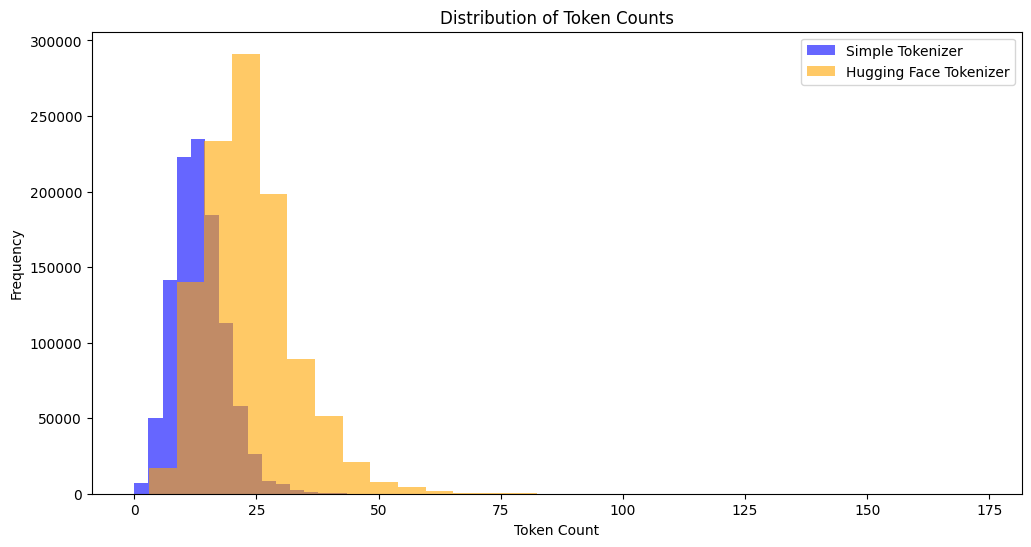

In [98]:
# Plot token count distributions
plt.figure(figsize=(12, 6))
plt.hist(df["simple_token_count"], bins=30, alpha=0.6, label="Simple Tokenizer", color="blue")
plt.hist(df["hf_token_count"], bins=30, alpha=0.6, label="Hugging Face Tokenizer", color="orange")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.title("Distribution of Token Counts")
plt.legend()
plt.show()


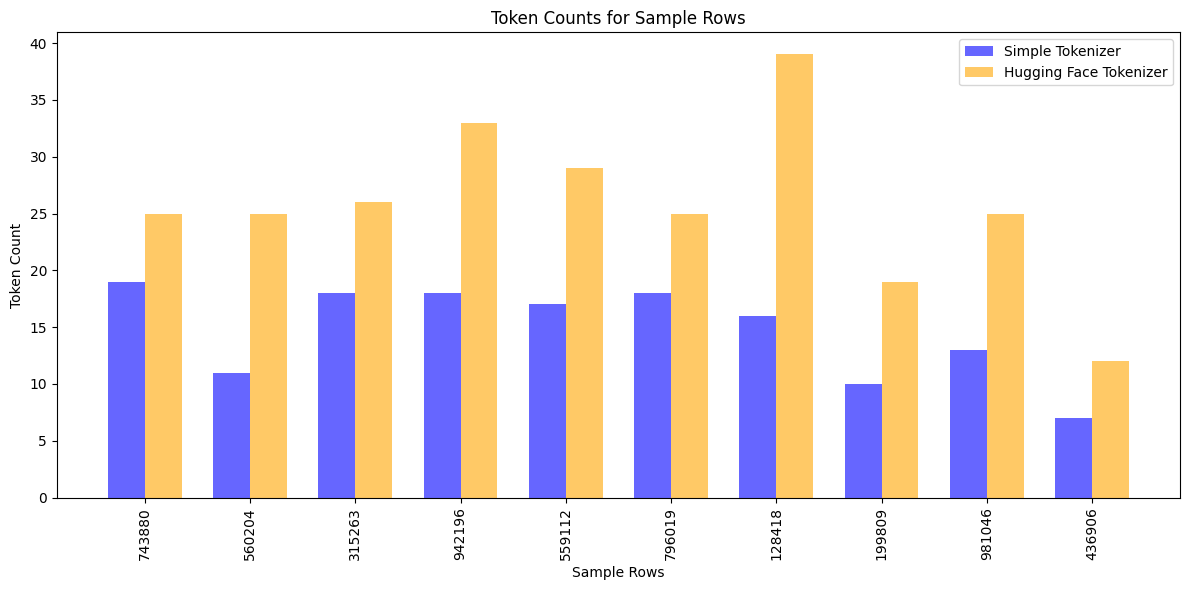

In [99]:
# Select a random sample of 10 rows
sample = df.sample(10, random_state=42)

# Plot token counts for the sample
x = range(len(sample))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x, sample["simple_token_count"], width=width, label="Simple Tokenizer", color="blue", alpha=0.6)
plt.bar([i + width for i in x], sample["hf_token_count"], width=width, label="Hugging Face Tokenizer", color="orange", alpha=0.6)
plt.xlabel("Sample Rows")
plt.ylabel("Token Count")
plt.title("Token Counts for Sample Rows")
plt.xticks([i + width / 2 for i in x], sample.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


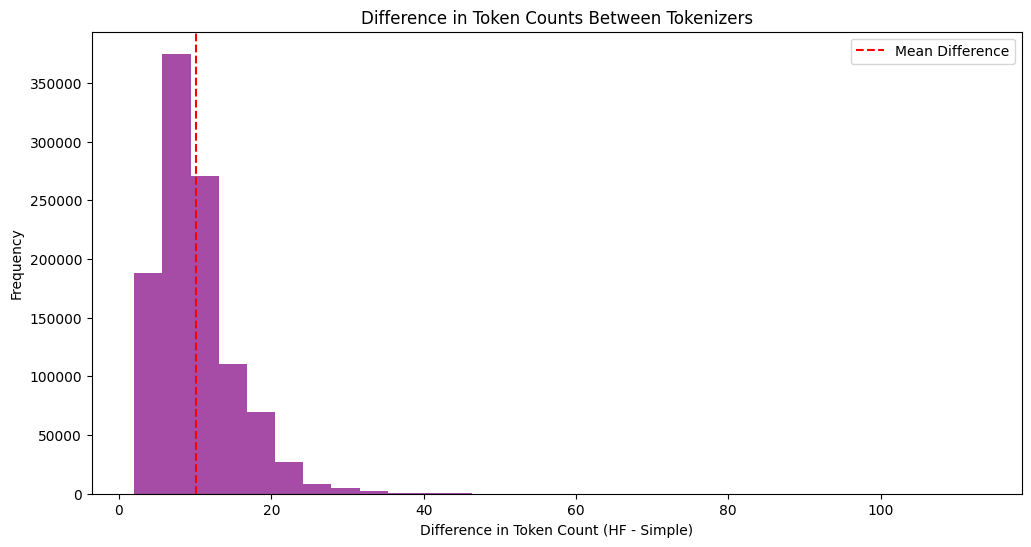

In [28]:
# Compute token count differences
df["token_count_difference"] = df["hf_token_count"] - df["simple_token_count"]

# Plot token count differences
plt.figure(figsize=(12, 6))
plt.hist(df["token_count_difference"], bins=30, color="purple", alpha=0.7)
plt.axvline(df["token_count_difference"].mean(), color="red", linestyle="--", label="Mean Difference")
plt.xlabel("Difference in Token Count (HF - Simple)")
plt.ylabel("Frequency")
plt.title("Difference in Token Counts Between Tokenizers")
plt.legend()
plt.show()


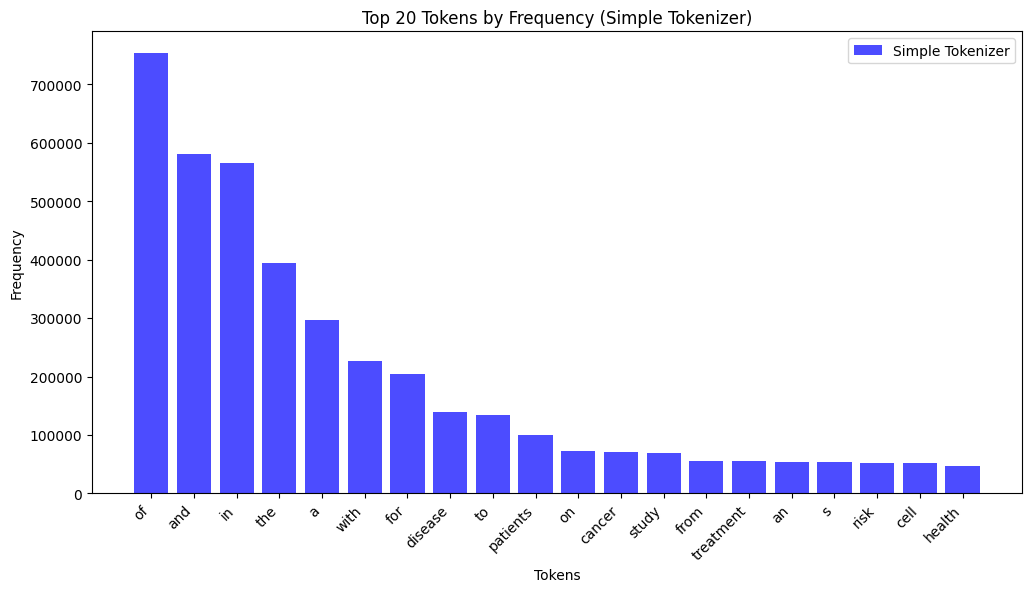

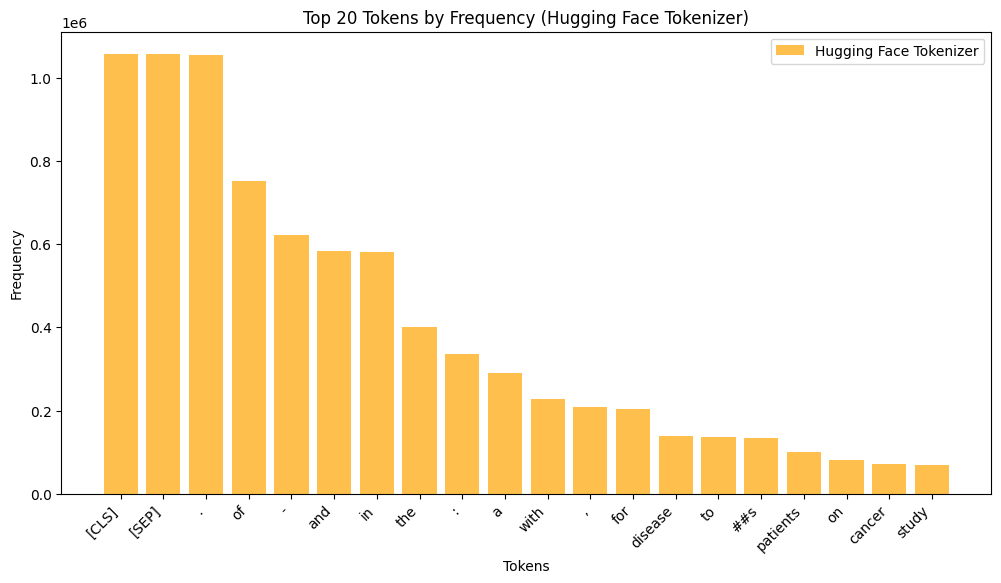

In [103]:
from collections import Counter

# Flatten token lists and calculate frequencies
simple_token_flat = [token for tokens in df["title_tokens_simple"] for token in tokens]
hf_token_flat = [token for tokens in df["title_tokens_hf"] for token in tokens]

# Get top 20 tokens by frequency
simple_token_freq = Counter(simple_token_flat).most_common(20)
hf_token_freq = Counter(hf_token_flat).most_common(20)

# Plot token frequency for Simple Tokenizer
plt.figure(figsize=(12, 6))
simple_tokens, simple_freqs = zip(*simple_token_freq)
plt.bar(simple_tokens, simple_freqs, color="blue", alpha=0.7, label="Simple Tokenizer")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.title("Top 20 Tokens by Frequency (Simple Tokenizer)")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.show()

# Plot token frequency for Hugging Face Tokenizer
plt.figure(figsize=(12, 6))
hf_tokens, hf_freqs = zip(*hf_token_freq)
plt.bar(hf_tokens, hf_freqs, color="orange", alpha=0.7, label="Hugging Face Tokenizer")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.title("Top 20 Tokens by Frequency (Hugging Face Tokenizer)")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Join tokens for TF-IDF analysis
df["simple_text"] = df["title_tokens_simple"].apply(lambda tokens: " ".join(tokens))
df["hf_text"] = df["title_tokens_hf"].apply(lambda tokens: " ".join(tokens))

# TF-IDF for Simple Tokenizer
tfidf_simple = TfidfVectorizer(max_features=20)
simple_tfidf_matrix = tfidf_simple.fit_transform(df["simple_text"])
simple_tfidf_df = pd.DataFrame(simple_tfidf_matrix.toarray(), columns=tfidf_simple.get_feature_names_out())

# TF-IDF for Hugging Face Tokenizer
tfidf_hf = TfidfVectorizer(max_features=20)
hf_tfidf_matrix = tfidf_hf.fit_transform(df["hf_text"])
hf_tfidf_df = pd.DataFrame(hf_tfidf_matrix.toarray(), columns=tfidf_hf.get_feature_names_out())

# TF-IDF for SpaCy fields
df["spacy_abstract_text"] = df["disease_abstract_spacy"].apply(lambda entities: " ".join(entities))
df["spacy_title_text"] = df["disease_title_spacy"].apply(lambda entities: " ".join(entities))

tfidf_spacy_abstract = TfidfVectorizer(max_features=20)
spacy_abstract_matrix = tfidf_spacy_abstract.fit_transform(df["spacy_abstract_text"])
spacy_abstract_tfidf_df = pd.DataFrame(spacy_abstract_matrix.toarray(), columns=tfidf_spacy_abstract.get_feature_names_out())

tfidf_spacy_title = TfidfVectorizer(max_features=20)
spacy_title_matrix = tfidf_spacy_title.fit_transform(df["spacy_title_text"])
spacy_title_tfidf_df = pd.DataFrame(spacy_title_matrix.toarray(), columns=tfidf_spacy_title.get_feature_names_out())

print("TF-IDF Matrix (SpaCy Abstract):")
print(spacy_abstract_tfidf_df.head())
print("\nTF-IDF Matrix (SpaCy Title):")
print(spacy_title_tfidf_df.head())

In [ ]:
from wordcloud import WordCloud

# Generate word clouds
simple_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(simple_token_flat))
hf_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(hf_token_flat))

# Plot word clouds
plt.figure(figsize=(12, 6))
plt.imshow(simple_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: Simple Tokenizer")
plt.show()

plt.figure(figsize=(12, 6))
plt.imshow(hf_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: Hugging Face Tokenizer")
plt.show()


In [27]:
#df

### WORDS PER EACH YEAR, ANALYSIS

In [ ]:
df

### Variable: `journal`|

In [29]:
journal_counts = df["journal"].value_counts(dropna=False)
print("Top 20 journals:")
print(journal_counts.head(20))

Top 20 journals:
journal
Scientific reports                                                                                      8778
Clinical infectious diseases : an official publication of the Infectious Diseases Society of America    5953
Nature communications                                                                                   5537
International journal of molecular sciences                                                             4551
Journal of virology                                                                                     4061
Cancer                                                                                                  4046
The Journal of infectious diseases                                                                      4021
The American journal of cardiology                                                                      3867
The Journal of biological chemistry                                                                    

In [12]:
# # long time to process it but overall cutoff does not make make new categories or make less categories so we will be staying with preprocessed journals
# import pandas as pd
# import difflib

# def basic_clean_journal(j):
#     if not isinstance(j, str):
#         return str(j)
#     return j.lower().strip().replace(".", "")

# def fuzzy_match_journal(j, known_journals, cutoff=0.8):
#     best = difflib.get_close_matches(j, known_journals, n=1, cutoff=cutoff)
#     return best[0] if best else j

# # 1) Basic cleaning
# df["journal_clean_basic"] = df["journal"].apply(basic_clean_journal)

# # 2) Original number of categories
# original_unique_categories = df["journal_clean_basic"].nunique()
# print("Original number of categories (cleaned):", original_unique_categories)

# # 3) Build known_journals from unique cleaned names
# known_journals = df["journal_clean_basic"].dropna().unique().tolist()

# # 4) Fuzzy match each row
# df["journal_fuzzy"] = df["journal_clean_basic"].apply(
#     lambda x: fuzzy_match_journal(x, known_journals, cutoff=0.4)
# )

# # 5) Number of categories AFTER fuzzy unification
# fuzzy_unique_categories = df["journal_fuzzy"].nunique()
# print("Number of categories after fuzzy unification:", fuzzy_unique_categories)

# # 6) Compare
# df["journal_match_same"] = (df["journal_clean_basic"] == df["journal_fuzzy"])


In [15]:
## Drop the unwanted columns 
#df = df.drop(columns=["journal_clean_basic", "journal_fuzzy", "journal_match_same"]).copy()

C:\Users\macie\AppData\Local\Temp\ipykernel_30340\3917490531.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


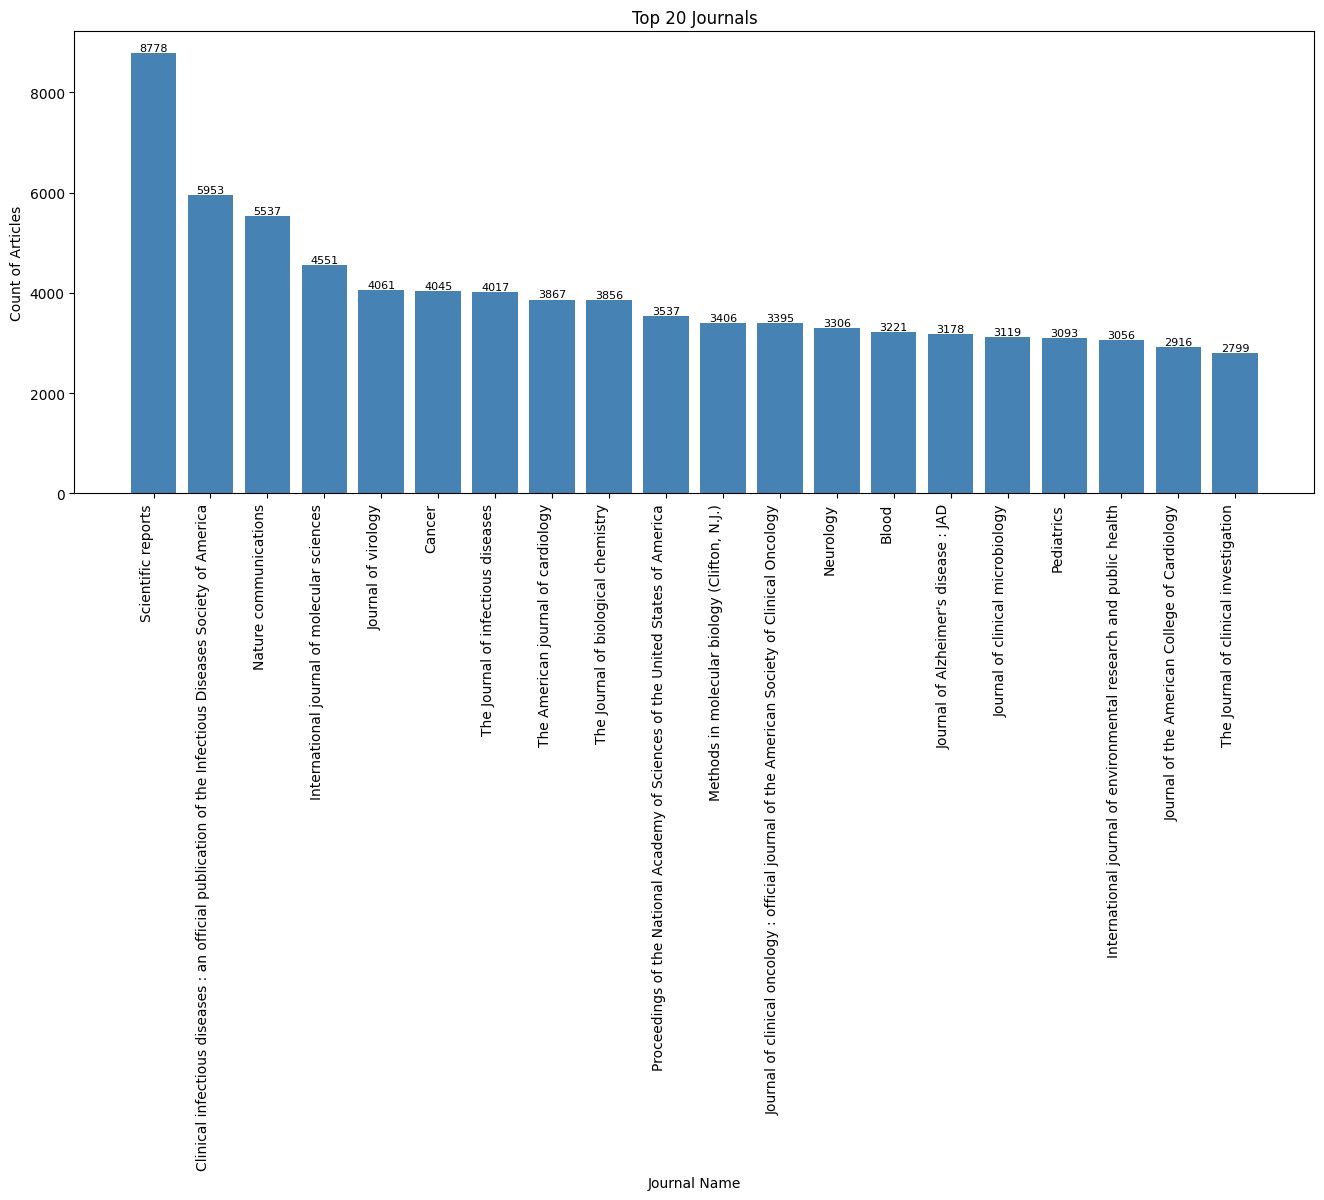

In [39]:
import matplotlib.pyplot as plt

journal_counts = df["journal"].value_counts().head(20)

plt.figure(figsize=(16, 6))
bars = plt.bar(range(len(journal_counts)), journal_counts.values, color='steelblue')

# X-ticks
plt.xticks(range(len(journal_counts)), journal_counts.index, rotation=90, ha='right')
plt.title("Top 20 Journals")
plt.xlabel("Journal Name")
plt.ylabel("Count of Articles")

# Label each bar with its count
for i, rect in enumerate(bars):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, height,
             f"{int(height)}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
journal_counts = df["journal"].value_counts().head(20)

plt.figure(figsize=(12,6))
bars = plt.bar(range(len(journal_counts)), journal_counts.values, color='steelblue')
plt.xticks(range(len(journal_counts)), journal_counts.index, rotation=45, ha='right')

for i, rect in enumerate(bars):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, height,
             f"{int(height)}", ha='center', va='bottom', fontsize=8)

plt.title("Top 20 Journals (with counts)")
plt.xlabel("Journal")
plt.ylabel("Count of Articles")
plt.tight_layout()
plt.show()


### Variable: `abstract`

In [ ]:
def simple_tokenize(text):
    """
    Example of a basic approach:
    - Lowercase
    - Remove punctuation or digits if you want
    - Split on whitespace
    """
    import re
    if not isinstance(text, str) or not text.strip():
        return []
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    return text.split()

from transformers import AutoTokenizer

# Hugging Face tokenizer from, e.g. "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def huggingface_tokenize(text, max_len=512):
    """
    Use the Hugging Face tokenizer to split text into tokens (subwords).
    We'll specify truncation to avoid index errors if text is too long.
    """
    if not isinstance(text, str) or not text.strip():
        return []
    # We'll do 'tokenize' approach, but we can also do 'encode' with truncation=True
    # For demonstration, let's do 'encode' so we can specify max_length.
    # This returns list of IDs, we can convert them back to tokens if we want.
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        return_token_type_ids=False,
        return_attention_mask=False
    )
    # Now convert IDs back to tokens to see subwords
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"])
    return tokens

# Example usage on df["abstract"]
df["abstract_tokens_simple"] = df["abstract"].apply(simple_tokenize)

# Hugging Face subword approach, with truncation
df["abstract_tokens_hf"] = df["abstract"].apply(lambda txt: huggingface_tokenize(txt, max_len=512))


In [ ]:
### authors

In [ ]:
df["authors_list"] = df["authors"].fillna("").str.split(";").apply(
    lambda x: [a.strip() for a in x if a.strip()]
)

In [ ]:
import pandas as pd
from collections import Counter

df["authors_list"] = (
    df["authors"]
    .fillna("")
    .str.split(";")
    .apply(lambda x: [a.strip() for a in x if a.strip()])
)

# Now each row has a Python list of authors
author_counter = Counter()

for authors in df["authors_list"]:
    author_counter.update(authors)

# Inspect top 20 authors
for author, freq in author_counter.most_common(20):
    print(author, freq)


In [ ]:
### affiliations

In [ ]:
df["affiliations_list"] = df["affiliations"].fillna("").str.split(";").apply(
    lambda x: [aff.strip() for aff in x if aff.strip()]
)


In [ ]:
aff_counter = df["affiliations"].fillna("").value_counts()
print("Top 20 affiliations:")
print(aff_counter)


In [ ]:
aff_freq = df["affiliations"].value_counts(dropna=False)
print("Number of unique affiliations:", len(aff_freq))
print("Top 20 affiliation strings:")
print(aff_freq.head(20))


In [ ]:
### mesh_terms

In [ ]:
# df["mesh_list"] = df["mesh_terms"].fillna("").str.split(";").apply(
#     lambda x: [m.strip() for m in x if m.strip()]
# )
df["mesh_list"] = (
    df["mesh_terms"]
    .fillna("")  # replace NaN with empty string
    .str.split(";")
    .apply(lambda x: [m.strip() for m in x if m.strip()])  # strip spaces, remove empties
)


In [ ]:
from collections import Counter

mesh_counter = Counter()
for mesh_terms in df["mesh_list"]:
    # mesh_terms is a list, e.g. ["Adolescent", "Adult", ...]
    mesh_counter.update(mesh_terms)

# Turn counter into a DataFrame sorted by frequency
mesh_freq_df = pd.DataFrame(mesh_counter.most_common(), columns=["mesh_term", "count"])
mesh_freq_df.head(20)


In [ ]:
# Explode the list so each row in df_exploded is one MeSH term
df_exploded = df.explode("mesh_list")
# Then we can do a value_counts on the single item
mesh_freq = df_exploded["mesh_list"].value_counts(dropna=False)
print("Number of unique MeSH terms:", len(mesh_freq))
print("Top 20 MeSH terms:")
print(mesh_freq.head(20))


In [ ]:
import pandas as pd
from collections import Counter
import time

def author_mesh_combos_in_chunks(df, chunk_size=100_000):
    """
    For each chunk of df, explode 'authors_list' and 'mesh_list'
    and compute counts of (author, mesh) combos, then combine.
    """
    combo_counter = Counter()
    num_rows = len(df)

    total_start = time.time()

    for start in range(0, num_rows, chunk_size):
        end = min(start + chunk_size, num_rows)
        chunk = df.iloc[start:end].copy()
        
        # Explode authors_list, then mesh_list
        chunk = chunk.explode("authors_list")
        chunk = chunk.explode("mesh_list")
        
        # Update counter
        for author, mesh in zip(chunk["authors_list"], chunk["mesh_list"]):
            if pd.isna(author) or pd.isna(mesh):
                continue
            combo_counter[(author, mesh)] += 1

        print(f"Processed rows {start} to {end} → combos so far: {len(combo_counter)}. "
              f"Elapsed: {time.time() - total_start:.2f}s")

    return combo_counter

# Usage:
combos = author_mesh_combos_in_chunks(df, chunk_size=100000)
# Then convert combos to a DataFrame if desired:
combos_df = pd.DataFrame([(*k, v) for k, v in combos.items()], columns=["author","mesh","count"])
combos_df.sort_values("count", ascending=False).head(20)


In [ ]:
### keywords

In [ ]:
### coi_statement

In [ ]:
### parsed_date

In [ ]:
## NEXT STEP: TOPIC MODELLING

# WHAT